Neural Network Code

CIS 581 001 Computational Learning

Instructor: Luis E Ortiz

Adapted by : Surya Subramani

In [1]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings

from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid, KFold, train_test_split

from numpy.random import default_rng
from sklearn.model_selection import KFold, cross_val_score

In [2]:
rng = default_rng()

# it is used to initialize weights to generate matrices
def random_uniform(n,m,R=[-1.0,1.0]):
  a, b = R[0], R[1]
  return (b - a) * rng.random((n,m)) + a


def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def deriv_sigmoid(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

def squared_error(y_true,y_pred):
  return 0.5 * (y_true - y_pred) ** 2

def deriv_squared_error(y_true,y_pred):
  return y_pred - y_true

def indicator(p):
  return p.astype(int)

def error_rate(y_true, y_pred):
  return 1.0 - np.mean(indicator(y_true == y_pred))

def identity(x):
  return x

def deriv_identity(x):
  return np.ones(x.shape)

In [3]:
def make_nunits(n,K,L,N):
  nunits = [n]
  for l in range(L):
    nunits.append(N)
  nunits.append(K)
  return nunits

def time_nnet(nunits):
  t = 0
  for l in range(len(nunits)-1):
    t += (nunits[l] + 1) * nunits[l+1]
  return t

In [4]:
class NNetBaseFunction:
    def __init__(self, f=None,df=None):
      self.f = f
      self.df = df 

    def deepcopy(self):
      return NNetBaseFunction(f=self.f, df=self.df) 

In [5]:
class NNetActivation(NNetBaseFunction):
    def __init__(self, f=sigmoid,df=deriv_sigmoid):
      super().__init__(f=f,df=df)

    def deepcopy(self):
      return NNetActivation(f=self.f, df=self.df) 

In [6]:
class NNetLoss(NNetBaseFunction):
  def __init__(self, f=squared_error,df=deriv_squared_error):
    super().__init__(f=f,df=df)

  def deepcopy(self):
    return NNetLoss(f=self.f, df=self.df)

In [7]:
class NNetMetric(NNetBaseFunction):
  def __init__(self, f=error_rate):
    super().__init__(f=f,df=None)

  def deepcopy(self):
    return NNetMetric(f=self.f)

In [8]:
# this same type neurons in layer
class NNetLayer:
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(), initializer=random_uniform):
    self.n_in = n_in
    self.n_out = n_out
    if initializer is None:
      initializer =  lambda n, m : np.zeros((n,m))
    self.initializer = initializer
    if W is None:
      W = self.initializer(n_out,n_in+1)
    else: 
      self.n_in, self.n_out = W.shape[1]-1, W.shape[0]
    self.W = W
    self.unit = unit

  def ds(self, x):
    return self.unit.df(x)

  def deepcopy(self):
    return NNetLayer(n_in=self.n_in,n_out=self.n_out,W=self.W.copy(),
                     unit=self.unit)

  def copy_layer(self, layer):
    self.W[:] = layer.W[:]
    return self

  # assumes x[0,:] = +1
  def aggregation_with_dummy_input(self, x):
    return np.matmul(self.W,x)

  def aggregation(self, x):
    if x.shape[0] == self.W.shape[1]:
      x_tmp = x
    else: 
      x_tmp = np.ones(W.shape[1],x.shape[1])
      x_tmp[1:,:] = x
    return self.aggregation_with_dummy_input(x_tmp)

  def activation(self, x):
    return self.unit.f(self.aggregation(x))

  def set_x(self, x):
    return x

  def set_y(self, y):
    return y

  def get_y(self):
    return None
  

In [9]:
#it allows to handle input units
class NNetIdentityLayer (NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None):
    super().__init__(n_in=n_in,n_out=n_out,W=W,
                     unit=NNetActivation(identity,deriv_identity))

In [10]:
class NNetLayerProp(NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(sigmoid,deriv_sigmoid),m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=unit)
    # self.y = np.ones((n_out+1,m))
    # self.y[1:,:] = 0
    # self.delta = np.zeros((n_out+1,m))
    self.x = None
    self.y = None
    self.delta = None

  def deepcopy(self):
    copy = super().deepcopy()
    # Input is not "stored" by layer
    copy.x = self.x
    copy.y = None if self.y is None else self.y.copy()
    copy.delta = None if self.delta is None else self.delta.copy()
    return copy

  def set_x(self, x):
    self.x = x
    return x

  def set_y(self, y):
    self.y = y
    return y

  def set_delta(self, delta):
    self.delta = delta
    return delta

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def get_delta(self):
    return self.delta

  def dW(self):
    return np.matmul(self.delta,self.x.T)

In [11]:
class NNetInputLayerProp(NNetLayerProp):
  def __init__(self,n_in=1,n_out=1,W=None,m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=NNetActivation(identity,deriv_identity))
    self.y = None

  def deepcopy(self):
    obj = super().deepcopy()
    obj.y = None if self.y is None else self.y.deepcopy()
    return obj


In [12]:
class NNetOptimizer:
  def __init__(self,loss=NNetLoss(),metric=NNetMetric()):
    self.loss = loss
    self.metric = metric
    self.best_nnet = None
    self.last_nnet = None
    self.train_err = []
    self.test_err = []
    return self

  def deepcopy(self):
    opt = NNetOptimizer(loss=self.loss.deepcopy(),metric=self.metric.deepcopy())
    opt.best_nnet = None if self.best_nnet is None else self.best_nnet.deepcopy()
    opt.last_nnet = None if self.best_nnet is None else self.last_nnet.deepcopy()
    opt.train_err = self.train_err.deepcopy()
    opt.test_err = self.test_err.deepcopy()
    return opt

  def run(self,nnet,X,y):
    return self.best_nnet

In [13]:
class NNet:
  def __init__(self, nunits=[0,0], unit=NNetActivation(sigmoid,deriv_sigmoid), 
               output_unit=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    self.nunits = nunits
    self.unit = unit
    self.output_unit = unit if output_unit is None else output_unit
    self.nlayers = len(nunits)
    self.layer = []
    self.layer.append(InputLayer(n_in=1,n_out=nunits[0]))

    for l in range(1,self.nlayers-1):
      self.layer.append(Layer(n_in=nunits[l-1],n_out=nunits[l],unit=unit))

    self.layer.append(Layer(n_in=nunits[-2],n_out=nunits[-1],
                                unit=self.output_unit))

  def copy(self, nnet_copy=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    if nnet_copy is None:
      nnet_copy = NNet(nunits=self.nunits,unit=self.unit,output_unit=self.output_unit, Layer=Layer, InputLayer=InputLayer)
    nnet_copy.copy_layers(self)
    return nnet_copy

  def deepcopy(self, nnet_copy=None):
    nnet_copy = self.copy(nnet_copy=nnet_copy)

    nnet_copy.nunits = copy.deepcopy(self.nunits)
    nnet_copy.unit = self.unit.deepcopy()
    nnet_copy.output_unit = self.output_unit.deepcopy()

    for l in range(1,self.nlayers):
      nnet_copy.layer[l] = self.layer[l].deepcopy()

    return nnet_copy

  def copy_layers(self, nnet_copy_from):
    for l in range(self.nlayers):
      self.layer[l].copy_layer(nnet_copy_from.layer[l])
    return self

  def error1(self, X, y, loss=squared_error, metric=None):
    output = self.forwardprop(X.T)
    #print(output)
    err = np.mean(loss(y.T, output))
    err_rate = 1.0 if metric is None else metric(y.T,output)
    return err, err_rate, output

  def error(self, X, y, loss=squared_error, metric=None):
    output = self.forwardprop(X.T)
    err = np.mean(loss(y.T, output))
    err_rate = 1.0 if metric is None else metric(y.T,output)
    return err, err_rate

  def forwardprop(self,X):
    m = X.shape[1]
    out_vals = np.ones((X.shape[0]+1,m))
    out_vals[1:,:] = X
    self.layer[0].set_y(out_vals)

    for l in range(1,self.nlayers):
      self.layer[l].set_x(self.layer[l-1].get_y())
      del out_vals
      out_vals = np.ones((self.nunits[l]+1,m))
      out_vals[1:,:] = self.layer[l].activation(self.layer[l].get_x())
      self.layer[l].set_y(out_vals)

    return out_vals[1:,:]

  def backprop(self,X,y,dE='deriv_squared_error'):
    net_output = self.forwardprop(X)

    layer = self.layer[self.nlayers-1]
    layer.set_delta(layer.ds(net_output) * dE(y,net_output))

    for l in range(self.nlayers-1,1,-1):
      next_layer = self.layer[l]
      layer = self.layer[l-1]
      x = layer.get_y()[1:,:]
      d = next_layer.delta
      layer.set_delta(layer.ds(x) * np.matmul(next_layer.W[:,1:].T,d))

    dW = []
    for l in range(self.nlayers):
      dW.append(None)

    for l in range(self.nlayers-1,0,-1):
      dW[l] = self.layer[l].dW() 

    return dW

  def fit(self, X, y, X_test=None, y_test=None, optimizer=None, verbose=0):
    if optimizer is None:
      optimizer = NNetGDOptimizer(loss=NNetLoss())

    best_nnet = optimizer.run(self,X,y,X_test,y_test,verbose)

    self.copy_layers(best_nnet)

    return self


In [14]:
class NNetGDOptimizer(NNetOptimizer):
  def __init__(self,loss=NNetLoss(),max_iters=100, learn_rate=1, reg_param=0, 
               change_thresh=1e-4, change_err_thresh=1e-6,metric=NNetMetric()):
    super().__init__(loss=loss,metric=metric)
    self.max_iters = max_iters
    self.learn_rate = learn_rate
    self.reg_param = reg_param
    self.change_thresh = change_thresh
    self.change_err_thresh = change_err_thresh

  def deepcopy(self):
    opt = super().deepcopy()
    return NNetGDOptimizer(loss=opt.loss, max_iters=self.max_iters, learn_rate=self.learn_rate, reg_param=self.reg_param, 
               change_thresh=self.change_thresh, change_err_thresh=self.change_err_thresh,metric=opt.metric)

  def run(self, nnet, X, y, X_test=None, y_test=None, verbose=0):

    eval_test = X_test is not None and y_test is not None
    new_nnet = NNet(nunits=nnet.nunits,unit=nnet.unit,output_unit=nnet.output_unit,Layer=NNetLayerProp,InputLayer=NNetInputLayerProp)
    new_nnet.copy_layers(nnet)

    t = 0
    max_change = math.inf
    min_change_err = math.inf

    train_err = []
    test_err = []
    y_p = []
    err, err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
    if verbose > 0:
      print((err,err_rate))
    min_err, min_err_rate = err, err_rate
 
    if eval_test:
      cv_err,cv_err_rate ,cv_output = new_nnet.error1(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

    best_nnet = nnet.deepcopy()
    best_nnet.copy_layers(new_nnet)

    while min_change_err > self.change_err_thresh and max_change > self.change_thresh and t < self.max_iters:
      if verbose > 0:
        print(t)
        print("Backprop...")

      dW = new_nnet.backprop(X.T, y.T,dE=self.loss.df)
      
      if verbose > 0:
        print("done.")
        print("Update...")

      max_change = 0

      for l in range(new_nnet.nlayers-1,0,-1):
        delta_W = self.learn_rate * (dW[l] / m + self.reg_param * new_nnet.layer[l].W)
        new_nnet.layer[l].W[:] = new_nnet.layer[l].W[:] - delta_W[:]
        max_change = max(max_change, np.max(np.absolute(delta_W)))

      del dW[:]

      if verbose > 0:
        print("done.")

      last_err = err
      err,err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
      if verbose > 0:
        print((err,err_rate))
      min_change_err = np.absolute(err-last_err)


      if verbose > 0:
        print("max_change")
        print(max_change)

      if eval_test:
        cv_err,cv_err_rate,cv_output = new_nnet.error1(X_test, y_test, loss=self.loss.f, metric=self.metric.f)
        #print(cv_output)
      if verbose > 0:
        if eval_test:
          print("(test_err,test_err_rate)")
          print((cv_err,cv_err_rate))

      if err < min_err:
        min_err = err
        min_err_rate = err_rate
        best_nnet.copy_layers(new_nnet)

      t += 1

      train_err.append([err, err_rate])
      if eval_test:
        y_p.append(cv_output)
        test_err.append([cv_err, cv_err_rate])

    if verbose > 0:
      if eval_test:
        print("(best_train_err,best_train_err_rate)")
        print((min_err,min_err_rate))

    self.train_err = train_err
    self.test_err = test_err
    self.y_p = y_p

    return best_nnet

In [15]:
if __name__ == '__main__':
  D = np.loadtxt(r"C:\Users\SS Studios\Desktop\UMD_WINTER_2023\COURSES\CL\PROJECT 2\project_2_files_share\optdigits_train.dat")
  D_test = np.loadtxt(r"C:\Users\SS Studios\Desktop\UMD_WINTER_2023\COURSES\CL\PROJECT 2\project_2_files_share\optdigits_test.dat")
  D_trial = np.loadtxt(r"C:\Users\SS Studios\Desktop\UMD_WINTER_2023\COURSES\CL\PROJECT 2\project_2_files_share\optdigits_trial.dat")

In [16]:
  m, n = D.shape[0], D.shape[1]-1

  X = D[:,:-1].reshape(m,n)
  y = D[:,-1].reshape(m,1)

  out_enc = LabelBinarizer()
  y_ohe = out_enc.fit_transform(y)

  K = y_ohe.shape[1]

  m_test = D_test.shape[0]

  X_test = D_test[:,:-1].reshape(m_test,n)
  y_test = D_test[:,-1].reshape(m_test,1)

  y_test_ohe = out_enc.transform(y_test)

  m_trial = D_test.shape[0]

  X_trial = D_test[:,:-1].reshape(m_trial,n)
  y_trial = D_test[:,-1].reshape(m_trial,1)

  y_trial_ohe = out_enc.transform(y_test)

In [17]:
  def nnet_error_rate(y_true, y_pred):
    y_pred_label = np.argmax(y_pred,axis=0).reshape(-1,1)
    y_true_label = out_enc.inverse_transform(y_true.T).reshape(-1,1)
    return error_rate(y_true_label, y_pred_label)  

In [18]:
  nnet_metric = NNetMetric(f=nnet_error_rate)

In [19]:
MAX_ITERS = 50
MAX_NHIDU = 2**9
MAX_NHIDL = 2**2
MAX_M = 2000

MAX_NUNITS = make_nunits(n,K,MAX_NHIDL,MAX_NHIDU)
MAX_NNET_TIME = time_nnet(MAX_NUNITS)

MAX_TIME = MAX_M * MAX_NNET_TIME * MAX_ITERS


In [20]:
  print(n)
  print(K)
  print(m)
  print(m_test)


1024
10
1934
946


In [23]:
import pandas as pd

# MODEL - PERCEPTRON CROSS VALIDATION

In [30]:
#### PERCEPTRON
from tqdm import tqdm
k = 3
nunits = [1024,10]
learning_rate_cv = [4**0,4**1,4**2,4**3,4**4]
cv_method = KFold(n_splits=k, shuffle=False, random_state=None)
scores = []
for a in tqdm(learning_rate_cv, desc="Loading..."):
    for i, (train_idx, test_idx) in enumerate(cv_method.split(X, y_ohe)):
                X_cv_train, y_cv_train = X[train_idx], y_ohe[train_idx]
                X_cv_test, y_cv_test = X[test_idx], y_ohe[test_idx]


                nnet_time = time_nnet(nunits)

                R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

                print(R)
                # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

                opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = a, change_err_thresh=0, change_thresh=0)


                nnet = NNet(nunits=nunits)

                best_nnet = nnet.fit(X_cv_train,y_cv_train,X_cv_test,y_cv_test,optimizer=opt,verbose=0)
                train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)
                print(test_err[-1,1])
                print(test_err[-1,0])
                plt.plot(train_err[:,0])
                plt.plot(test_err[:,0])
                plt.xlabel("iterations")
                plt.ylabel("train / test error")
                plt.title("Proxy_error_learning_rate_{}_fold{}.png".format(a,i))
                plt.legend(["train_error","test_error"])
                plt.savefig("Graph1/Misclassification_error_learning_rate_{}_fold{}.png".format(a,i))
                plt.clf()

                plt.plot(train_err[:,1])
                plt.plot(test_err[:,1])
                plt.xlabel("iterations")
                plt.ylabel("train / test error")
                plt.title("Misclassification_error_learning_rate_{}_fold{}.png".format(a,i))
                plt.legend(["train_error","test_error"])
                plt.savefig("Graph2/Misclassification_error_learning_rate_{}_fold{}.png".format(a,i))
                plt.clf()
                
                scores.append([a,i,test_err[-1,1],train_err[-1,1],test_err[-1,0],train_err[-1,0]])
scoress = pd.DataFrame(scores)
scoress.columns = ["learn_rate","fold","misc_test","misc_train","RMSE_test","RMSE_train"]
scores1 = scoress.groupby("learn_rate")["misc_test","misc_train","RMSE_test","RMSE_train"].mean().reset_index()
print(scores1)
scores.to_csv("results/perceptron_all.csv",index = False)
scores1.to_csv("results/perceptron_avg.csv",index = False)
print("finish")

Loading...:   0%|                                                                                | 0/5 [00:00<?, ?it/s]

1000
0.10697674418604652
0.011618687456224151
1000
0.08062015503875974
0.010296920535394835
1000
0.11335403726708071
0.012912789916636724


Loading...:  20%|██████████████▏                                                        | 1/5 [02:29<09:56, 149.19s/it]

1000
0.09922480620155039
0.010622150920902568
1000
0.05581395348837215
0.00847519707590465
1000
0.09316770186335399
0.011046811847480293


Loading...:  40%|████████████████████████████▍                                          | 2/5 [05:05<07:39, 153.32s/it]

1000
0.07441860465116279
0.008313838395349006
1000
0.04031007751937987
0.008148102325507374
1000
0.07919254658385089
0.010100662147792733


Loading...:  60%|██████████████████████████████████████████▌                            | 3/5 [07:38<05:06, 153.43s/it]C:\Users\SS Studios\AppData\Local\Temp\ipykernel_11840\712941221.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


1000
0.07596899224806197
0.010318339137678854
1000
0.04496124031007753
0.00789953672553919
1000
0.08850931677018636
0.01144283344831499


Loading...:  80%|████████████████████████████████████████████████████████▊              | 4/5 [10:01<02:29, 149.06s/it]

1000
0.08682170542635659
0.010764102868531297
1000
0.054263565891472854
0.008406453596747585
1000
0.10248447204968947
0.012396133631358334


Loading...: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [12:24<00:00, 148.92s/it]


NameError: name 'pd' is not defined

<Figure size 640x480 with 0 Axes>

# MODEL - 1 TRAINING ALL DATA

In [30]:

nnet_time = time_nnet([1024,10])

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

#print(R)
# opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

opt = NNetGDOptimizer(metric=nnet_metric, max_iters=1000, learn_rate = 4**2, change_err_thresh=0, change_thresh=0)


nnet = NNet(nunits=[1024,10])

best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=0)
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)
print(test_err[-1,1])
print(test_err[-1,0])
plt.plot(train_err[:,0])
plt.plot(test_err[:,0])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("error_curve_Best_percetron_{}".format(16))
plt.legend(["train_error","test_error"])
plt.savefig('results/best_perceptron_proxy_error.png')
plt.clf()

plt.plot(train_err[:,1])
plt.plot(test_err[:,1])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("Misc_err_curve_Best_percetron_{}".format(16))
plt.legend(["train_error","test_error"])
plt.savefig('results/best_perceptron_Misc_error.png')
plt.clf()

temp = pd.DataFrame()
temp["misc_err_train"] = train_err[:,1]
temp["misc_err_test"] = test_err[:,1]
temp["p_err_train"] = train_err[:, 0 ]
temp["p_err_test"] = test_err[:, 0 ]
temp.to_csv("results/best_perceptronmodel_{}.csv".format(16),index = False)

0.039112050739957716
0.005532758745411491


<Figure size 640x480 with 0 Axes>

# Model 2 DEEP NEURAL NETWORK WITH n layer with n units

In [34]:
### DEEP NEURAL NETWORK
from tqdm import tqdm
k = 3
learning_rate_cv = [4**-2,4**-1,4**0,4**1,4**2]
cv_method = KFold(n_splits=k, shuffle=False, random_state=None)
scores_deep = []
layer_units = [16,64,256]
for p in tqdm(range(1,5)):
    for j in layer_units:
        for a in learning_rate_cv:
            for i, (train_idx, test_idx) in enumerate(cv_method.split(X, y_ohe)):
                        X_cv_train, y_cv_train = X[train_idx], y_ohe[train_idx]
                        X_cv_test, y_cv_test = X[test_idx], y_ohe[test_idx]

                        n_hidu = j
                        n_hidl = p

                        nunits = make_nunits(n,K,n_hidl,n_hidu)
                        print(nunits)
                        nnet_time = time_nnet(nunits)

                        R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))
                        #R = 1000
                        print(R)

                        # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

                        opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = a, change_err_thresh=0, change_thresh=0)


                        nnet = NNet(nunits=nunits)

                        best_nnet = nnet.fit(X_cv_train,y_cv_train,X_cv_test,y_cv_test,optimizer=opt,verbose=0)
                        train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)
                        print(p,j,a,i,test_err[-1,1])
                        plt.plot(train_err[:,0])
                        plt.plot(test_err[:,0])
                        plt.xlabel("iterations")
                        plt.ylabel("train / test error")
                        plt.title("Proxy_error_layer{}_units{}_learning_rate_{}_fold{}".format(p,j,a,i))
                        plt.legend(["train_error","test_error"])
                        plt.savefig('Graph_deep1/proxy_error_layer{}_units{}_learning_rate_{}_fold{}.png'.format(p,j,a,i))
                        plt.clf()

                        plt.plot(train_err[:,1])
                        plt.plot(test_err[:,1])
                        plt.xlabel("iterations")
                        plt.ylabel("train / test error")
                        plt.title("Misc_error_layer{}_units{}_learning_rate_{}_fold{}".format(p,j,a,i))
                        plt.legend(["train_error","test_error"])
                        plt.savefig('Graph_deep2/Misclassification_error_layer{}_units{}_learning_rate_{}_fold{}.png'.format(p,j,a,i))
                        plt.clf()
                        scores_deep.append([p,j,a,i,test_err[-1,1],train_err[-1,1],test_err[-1,0],train_err[-1,0]])
scoress = pd.DataFrame(scores_deep)
scoress.columns = ["numberlayers","layerunits","learn_rate","fold","misc_test","misc_train","RMSE_test","RMSE_train"]
scores1 = scoress.groupby(["numberlayers","layerunits","learn_rate"])["misc_test","misc_train","RMSE_test","RMSE_train"].mean().reset_index()
print(scores1)
scoress.to_csv("results/deep1_all.csv",index = False)
scores1.to_csv("results/deep2_avg.csv",index = False)
print("finish")

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1000
1 16 0.0625 0 0.4527131782945737
1000
1 16 0.0625 1 0.475968992248062
1000
1 16 0.0625 2 0.5916149068322981
1000
1 16 0.25 0 0.2945736434108527
1000
1 16 0.25 1 0.37054263565891477
1000
1 16 0.25 2 0.38975155279503104
1000
1 16 1 0 0.21705426356589153
1000
1 16 1 1 0.1705426356589147
1000
1 16 1 2 0.19409937888198758
1000


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_11840\712941221.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


1 16 4 0 0.16899224806201552
1000
1 16 4 1 0.19999999999999996
1000
1 16 4 2 0.18322981366459623
1000
1 16 16 0 0.13643410852713178
1000
1 16 16 1 0.0976744186046512
1000
1 16 16 2 0.16770186335403725
1000
1 64 0.0625 0 0.2093023255813954
1000
1 64 0.0625 1 0.19069767441860463
1000
1 64 0.0625 2 0.22360248447204967
1000
1 64 0.25 0 0.12713178294573646
1000
1 64 0.25 1 0.0728682170542636
1000
1 64 0.25 2 0.12577639751552794
1000
1 64 1 0 0.08992248062015507
1000
1 64 1 1 0.06666666666666665
1000
1 64 1 2 0.10248447204968947
1000
1 64 4 0 0.10077519379844957
1000
1 64 4 1 0.046511627906976716
1000
1 64 4 2 0.11645962732919257
1000
1 64 16 0 0.07751937984496127
1000
1 64 16 1 0.032558139534883734
1000
1 64 16 2 0.08695652173913049
258
1 256 0.0625 0 0.37209302325581395
258
1 256 0.0625 1 0.38604651162790693
258
1 256 0.0625 2 0.41770186335403725
258
1 256 0.25 0 0.15658914728682172
258
1 256 0.25 1 0.13178294573643412
258
1 256 0.25 2 0.19099378881987583
258
1 256 1 0 0.11627906976744184


 25%|████████████████████                                                            | 1/4 [32:09<1:36:29, 1929.75s/it]

1000
2 16 0.0625 0 0.6542635658914728
1000
2 16 0.0625 1 0.7209302325581395
1000
2 16 0.0625 2 0.6304347826086957
1000
2 16 0.25 0 0.33798449612403103
1000
2 16 0.25 1 0.4744186046511628
1000
2 16 0.25 2 0.43788819875776397
1000
2 16 1 0 0.28682170542635654
1000
2 16 1 1 0.2775193798449612
1000
2 16 1 2 0.3493788819875776
1000
2 16 4 0 0.15348837209302324
1000
2 16 4 1 0.2325581395348837
1000
2 16 4 2 0.2360248447204969
1000
2 16 16 0 0.2542635658914729
1000
2 16 16 1 0.12558139534883717
1000
2 16 16 2 0.16770186335403725
968
2 64 0.0625 0 0.2542635658914729
968
2 64 0.0625 1 0.23410852713178298
968
2 64 0.0625 2 0.2701863354037267
968
2 64 0.25 0 0.1224806201550388
968
2 64 0.25 1 0.09457364341085273
968
2 64 0.25 2 0.13354037267080743
968
2 64 1 0 0.0976744186046512
968
2 64 1 1 0.06356589147286817
968
2 64 1 2 0.13043478260869568
968
2 64 4 0 0.11317829457364337
968
2 64 4 1 0.07596899224806197
968
2 64 4 2 0.09472049689440998
968
2 64 16 0 0.11472868217054266
968
2 64 16 1 0.083720

 50%|███████████████████████████████████████                                       | 2/4 [1:05:25<1:05:37, 1968.82s/it]

1000
3 16 0.0625 0 0.6635658914728682
1000
3 16 0.0625 1 0.7255813953488373
1000
3 16 0.0625 2 0.796583850931677
1000
3 16 0.25 0 0.44496124031007755
1000
3 16 0.25 1 0.5596899224806202
1000
3 16 0.25 2 0.639751552795031
1000
3 16 1 0 0.2806201550387597
1000
3 16 1 1 0.4418604651162791
1000
3 16 1 2 0.3695652173913043
1000
3 16 4 0 0.2775193798449612
1000
3 16 4 1 0.2589147286821706
1000
3 16 4 2 0.21739130434782605
1000
3 16 16 0 0.2713178294573644
1000
3 16 16 1 0.21395348837209305
1000
3 16 16 2 0.3850931677018633
914
3 64 0.0625 0 0.3302325581395349
914
3 64 0.0625 1 0.27596899224806204
914
3 64 0.0625 2 0.35248447204968947
914
3 64 0.25 0 0.12713178294573646
914
3 64 0.25 1 0.10387596899224805
914
3 64 0.25 2 0.1490683229813664
914
3 64 1 0 0.09147286821705425
914
3 64 1 1 0.10387596899224805
914
3 64 1 2 0.0854037267080745
914
3 64 4 0 0.08372093023255811
914
3 64 4 1 0.06511627906976747
914
3 64 4 2 0.10869565217391308
914
3 64 16 0 0.28837209302325584
914
3 64 16 1 0.2046511627

 75%|████████████████████████████████████████████████████████████                    | 3/4 [1:45:40<36:12, 2172.27s/it]

1000
4 16 0.0625 0 0.8465116279069768
1000
4 16 0.0625 1 0.8542635658914729
1000
4 16 0.0625 2 0.8354037267080745
1000
4 16 0.25 0 0.6821705426356589
1000
4 16 0.25 1 0.7147286821705426
1000
4 16 0.25 2 0.8245341614906833
1000
4 16 1 0 0.5565891472868216
1000
4 16 1 1 0.5767441860465117
1000
4 16 1 2 0.3990683229813664
1000
4 16 4 0 0.3023255813953488
1000
4 16 4 1 0.39689922480620154
1000
4 16 4 2 0.3586956521739131
1000
4 16 16 0 0.5875968992248062
1000
4 16 16 1 0.57984496124031
1000
4 16 16 2 0.5838509316770186
866
4 64 0.0625 0 0.43100775193798446
866
4 64 0.0625 1 0.3534883720930233
866
4 64 0.0625 2 0.3695652173913043
866
4 64 0.25 0 0.15038759689922476
866
4 64 0.25 1 0.16899224806201552
866
4 64 0.25 2 0.19099378881987583
866
4 64 1 0 0.1209302325581395
866
4 64 1 1 0.10387596899224805
866
4 64 1 2 0.09472049689440998
866
4 64 4 0 0.10077519379844957
866
4 64 4 1 0.0976744186046512
866
4 64 4 2 0.1149068322981367
866
4 64 16 0 0.648062015503876
866
4 64 16 1 0.7131782945736433

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [2:31:00<00:00, 2265.03s/it]

    numberlayers  layerunits  learn_rate  misc_test  misc_train  RMSE_test  \
0              1          16      0.0625   0.506766    0.458373   0.037605   
1              1          16      0.2500   0.351623    0.289547   0.028289   
2              1          16      1.0000   0.193899    0.137805   0.016657   
3              1          16      4.0000   0.184074    0.107298   0.013209   
4              1          16     16.0000   0.133937    0.047565   0.010205   
5              1          64      0.0625   0.207867    0.173477   0.020524   
6              1          64      0.2500   0.108592    0.067479   0.012431   
7              1          64      1.0000   0.086358    0.034904   0.008329   
8              1          64      4.0000   0.087915    0.016286   0.007173   
9              1          64     16.0000   0.065678    0.000000   0.005950   
10             1         256      0.0625   0.391947    0.335838   0.031552   
11             1         256      0.2500   0.159789    0.100053 


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_11840\3932908731.py:55: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  scores1 = scoress.groupby(["numberlayers","layerunits","learn_rate"])["misc_test","misc_train","RMSE_test","RMSE_train"].mean().reset_index()


<Figure size 640x480 with 0 Axes>

[1024, 64, 64, 10] 968


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_5016\712941221.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


0.051797040169133224
0.004016143082864426


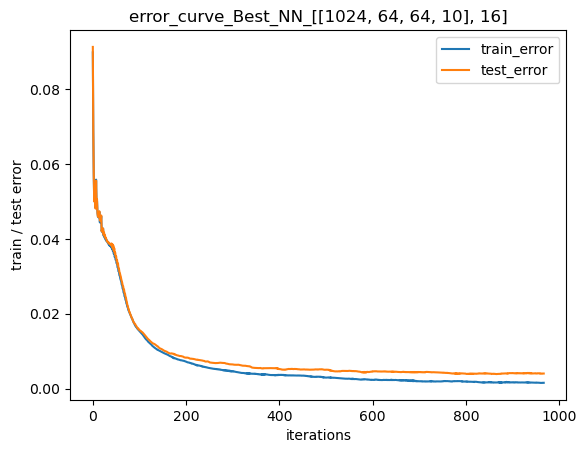

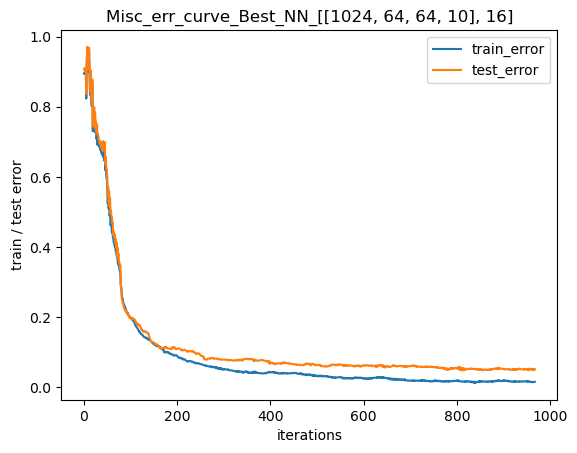

In [23]:
n_hidu = 64
n_hidl = 2
nunits = make_nunits(n,K,n_hidl,n_hidu)
nnet_time = time_nnet(nunits)
learn_rate = 16
R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))
#R = 1000
print(nunits,R)

# opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = learn_rate, change_err_thresh=0, change_thresh=0)


nnet = NNet(nunits=nunits)

best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe, optimizer=opt,verbose=0)
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)
print(test_err[-1,1])
print(test_err[-1,0])
plt.plot(train_err[:,0])
plt.plot(test_err[:,0])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("error_curve_Best_NN_{}".format([nunits,learn_rate]))
plt.legend(["train_error","test_error"])
#plt.savefig('results/best_NN_proxy_error.png')
plt.show()

plt.plot(train_err[:,1])
plt.plot(test_err[:,1])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("Misc_err_curve_Best_NN_{}".format([nunits,learn_rate]))
plt.legend(["train_error","test_error"])
#plt.savefig('results/best_NN_Misc_error.png')
plt.show()

# Model 2 Training all Data

[1024, 64, 10] 1000


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_5016\712941221.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


0.038054968287526414
0.003514877672951083


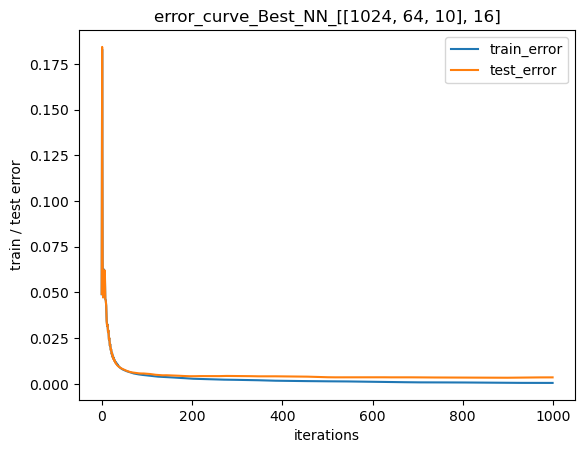

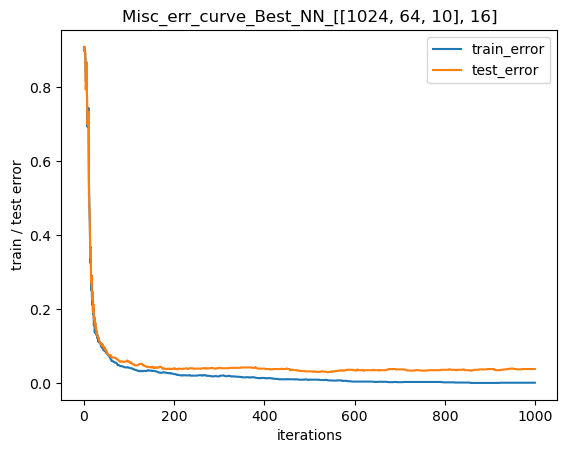

NameError: name 'pd' is not defined

In [21]:
n_hidu = 64
n_hidl = 1
nunits = make_nunits(n,K,n_hidl,n_hidu)
nnet_time = time_nnet(nunits)
learn_rate = 16
R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))
#R = 1000
print(nunits,R)

# opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = learn_rate, change_err_thresh=0, change_thresh=0)


nnet = NNet(nunits=nunits)

best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe, optimizer=opt,verbose=0)
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)
print(test_err[-1,1])
print(test_err[-1,0])
plt.plot(train_err[:,0])
plt.plot(test_err[:,0])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("error_curve_Best_NN_{}".format([nunits,learn_rate]))
plt.legend(["train_error","test_error"])
#plt.savefig('results/best_NN_proxy_error.png')
plt.show()

plt.plot(train_err[:,1])
plt.plot(test_err[:,1])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("Misc_err_curve_Best_NN_{}".format([nunits,learn_rate]))
plt.legend(["train_error","test_error"])
#plt.savefig('results/best_NN_Misc_error.png')
plt.show()

temp = pd.DataFrame()
temp["misc_err_train"] = train_err[:,1]
temp["misc_err_test"] = test_err[:,1]
temp["p_err_train"] = train_err[:, 0 ]
temp["p_err_test"] = test_err[:, 0 ]
#temp.to_csv("results/best_NN_{}.csv".format([nunits,learn_rate]),index = False)

# MODEL 2 DEEP NEURAL NET FIXED H LAYERS CROSS VALIDATION

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[1024, 64, 16, 10]
1000
64 16 0.015625 0 0.7224806201550388


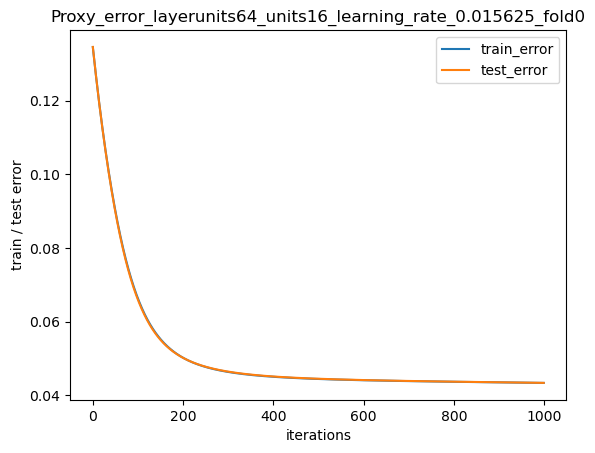

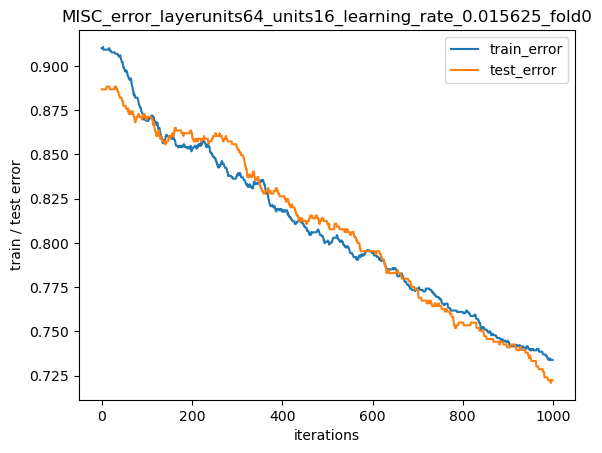

[1024, 64, 16, 10]
1000
64 16 0.015625 1 0.7302325581395348


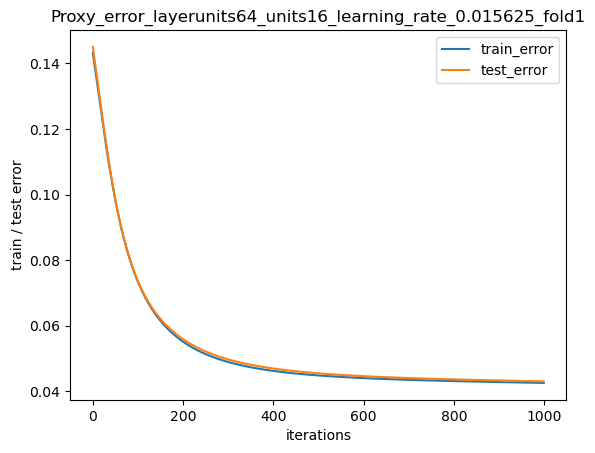

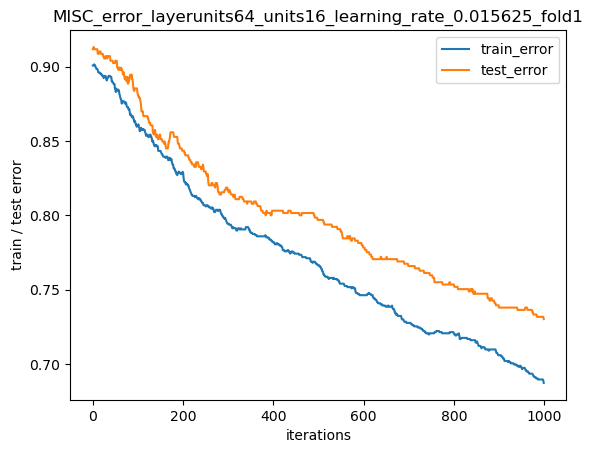

[1024, 64, 16, 10]
1000
64 16 0.015625 2 0.8757763975155279


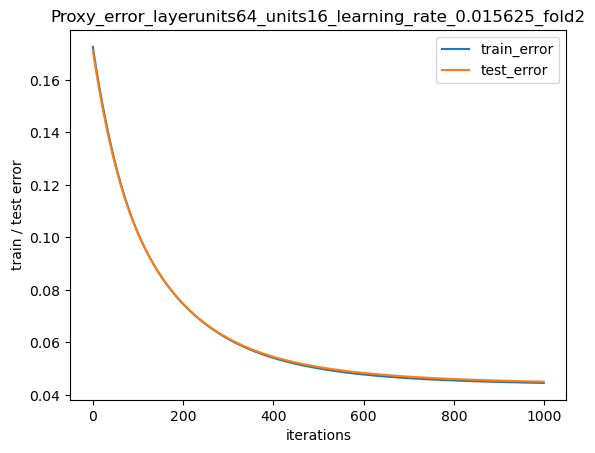

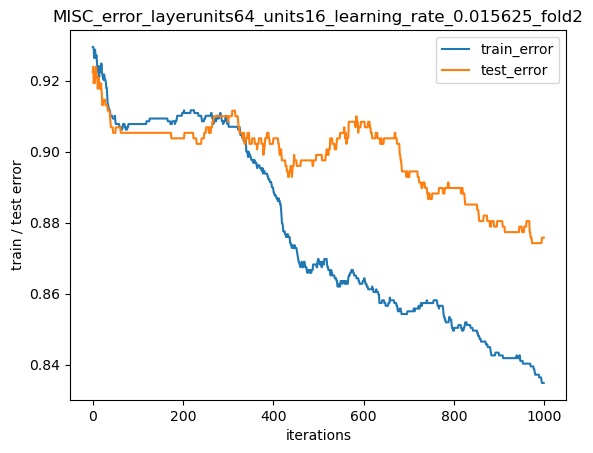

[1024, 64, 16, 10]
1000
64 16 0.0625 0 0.47131782945736433


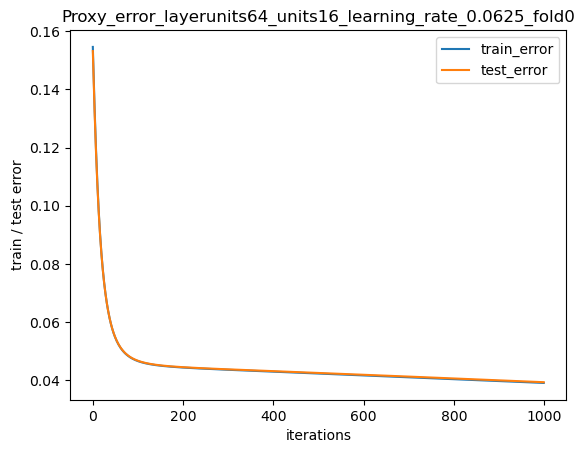

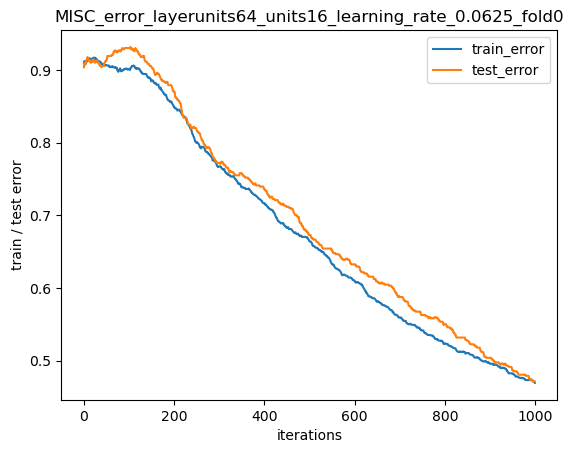

[1024, 64, 16, 10]
1000
64 16 0.0625 1 0.5069767441860464


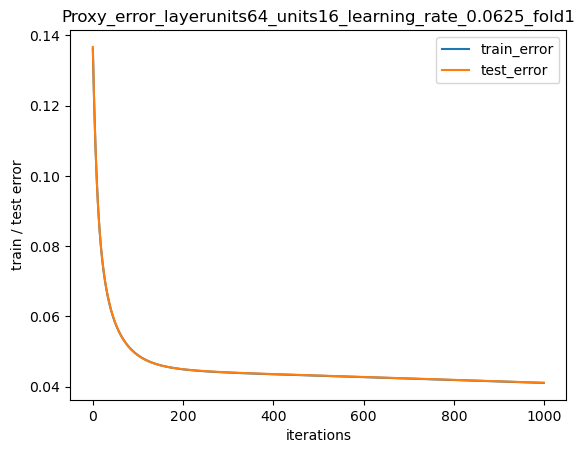

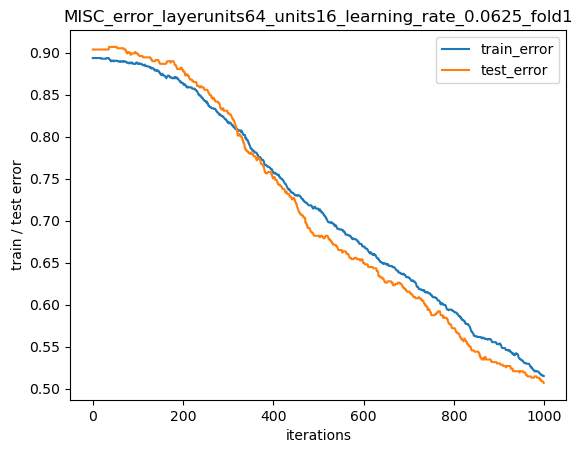

[1024, 64, 16, 10]
1000
64 16 0.0625 2 0.5248447204968945


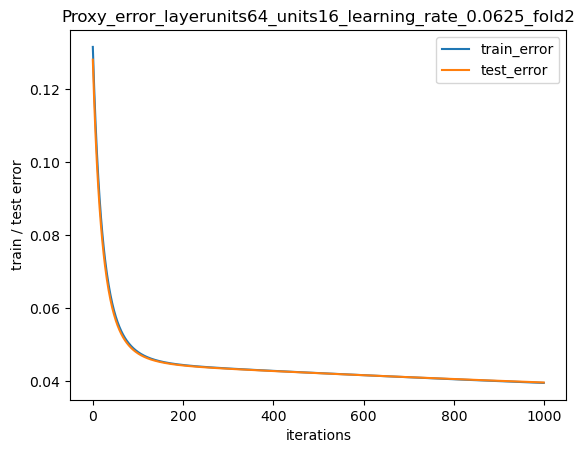

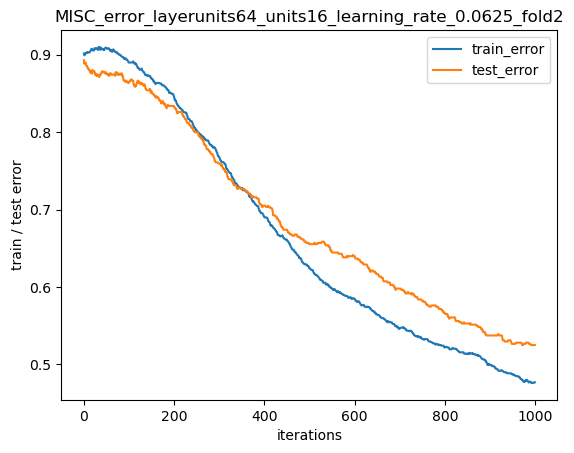

[1024, 64, 16, 10]
1000
64 16 0.25 0 0.3147286821705426


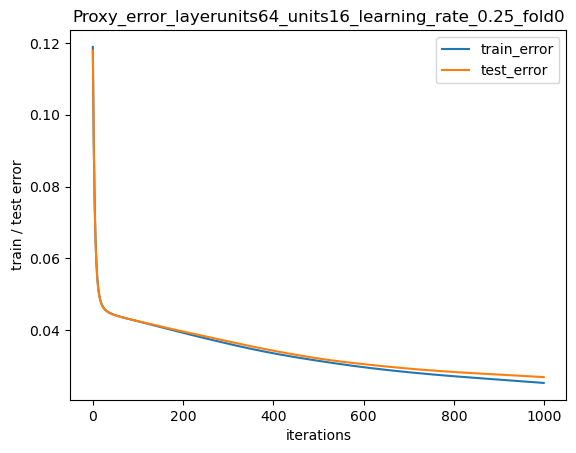

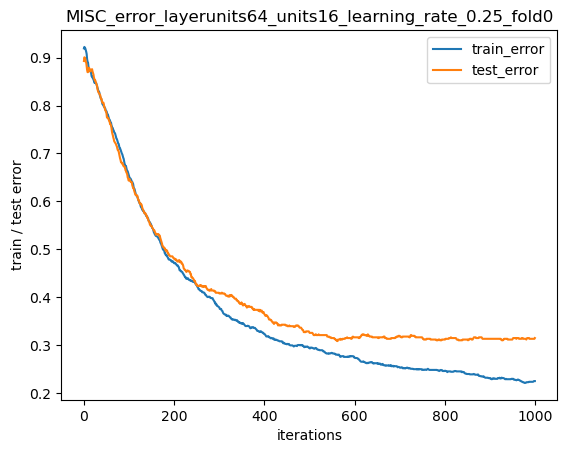

[1024, 64, 16, 10]
1000
64 16 0.25 1 0.3410852713178295


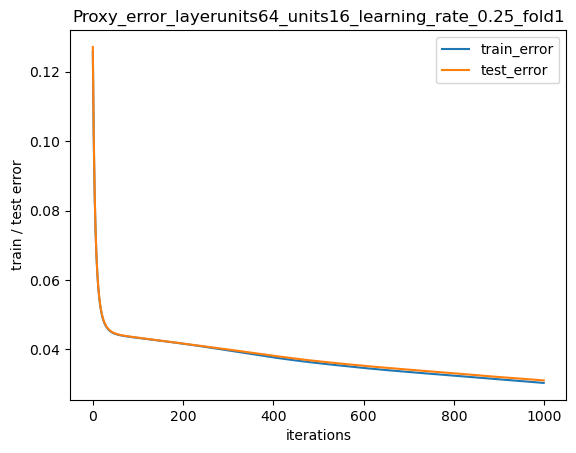

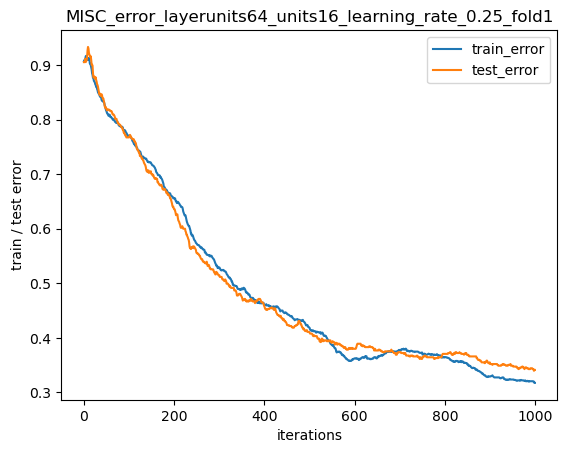

[1024, 64, 16, 10]
1000
64 16 0.25 2 0.3059006211180124


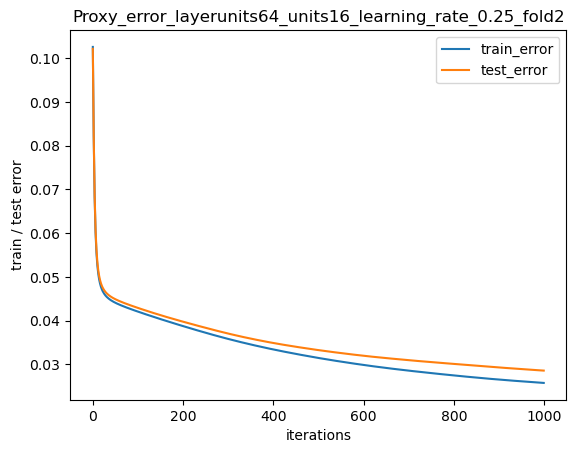

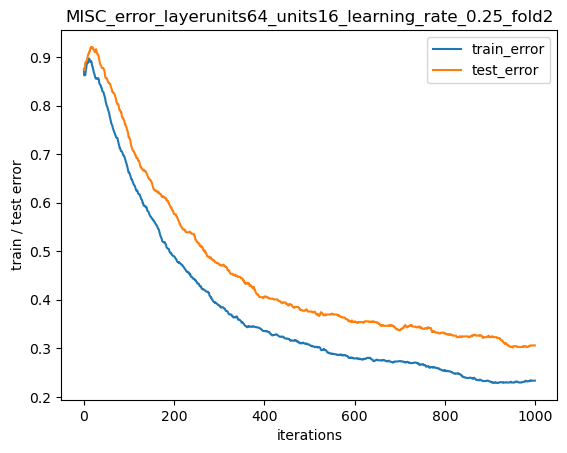

[1024, 64, 16, 10]
1000
64 16 1 0 0.1457364341085271


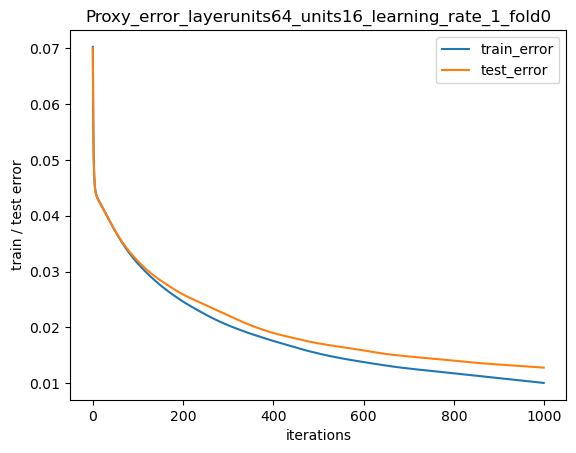

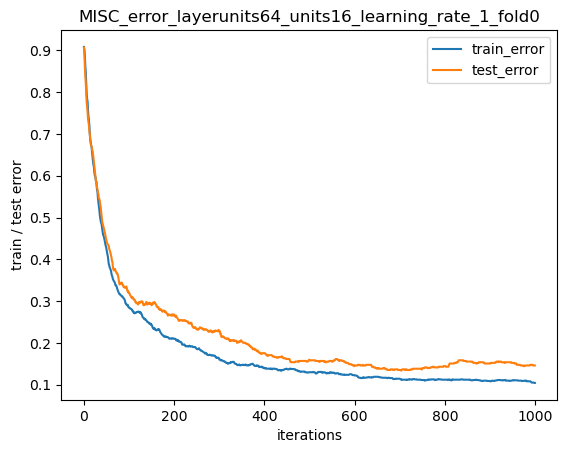

[1024, 64, 16, 10]
1000


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_3376\712941221.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


64 16 1 1 0.32403100775193794


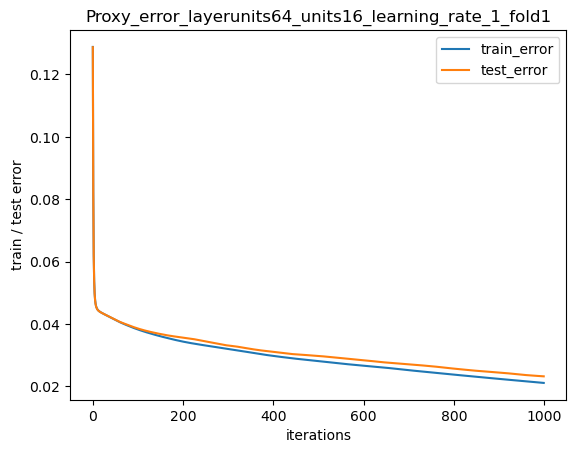

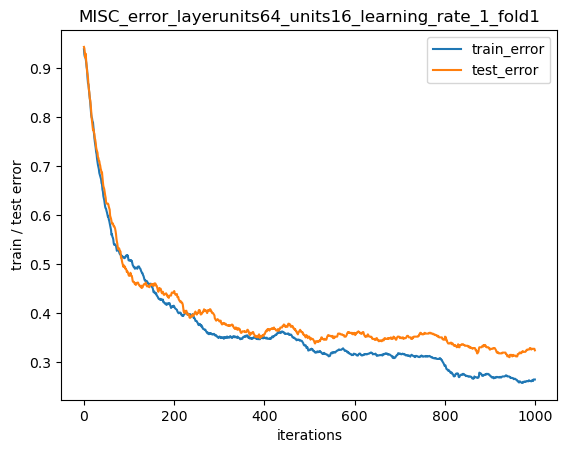

[1024, 64, 16, 10]
1000
64 16 1 2 0.20186335403726707


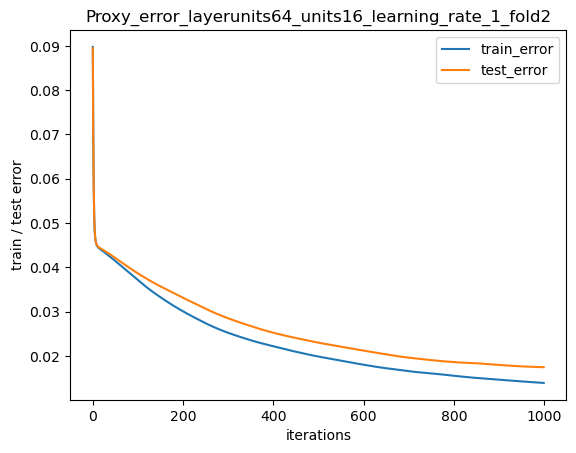

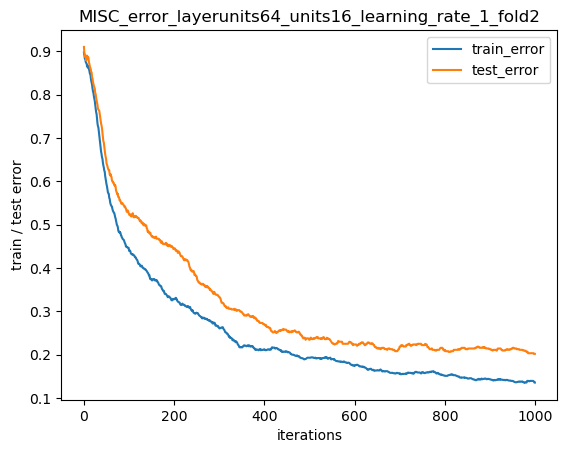

[1024, 64, 16, 10]
1000
64 16 4 0 0.16899224806201552


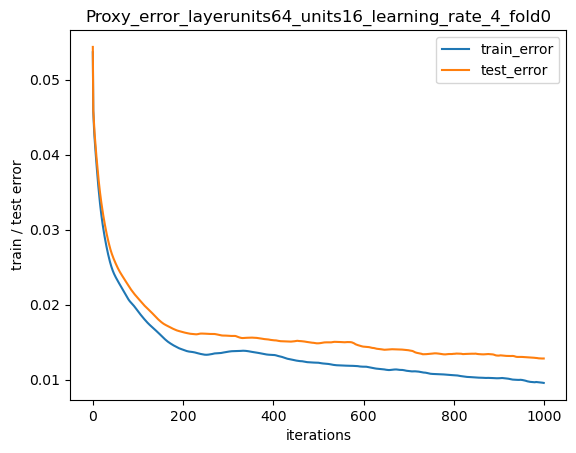

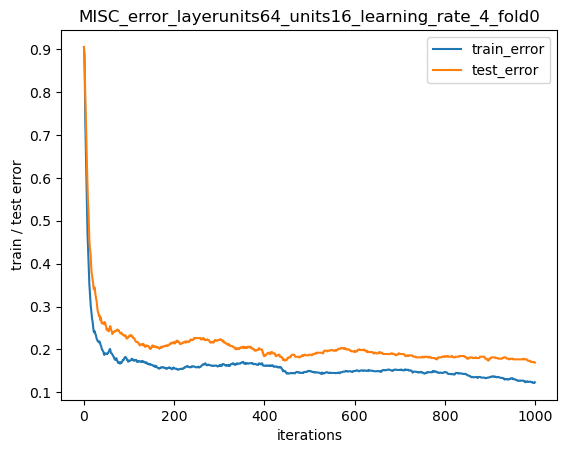

[1024, 64, 16, 10]
1000
64 16 4 1 0.1333333333333333


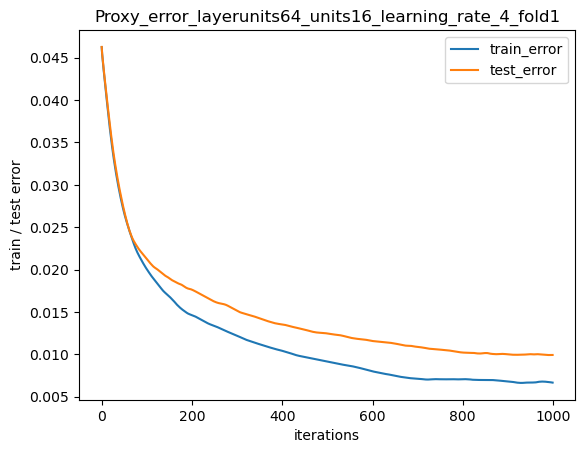

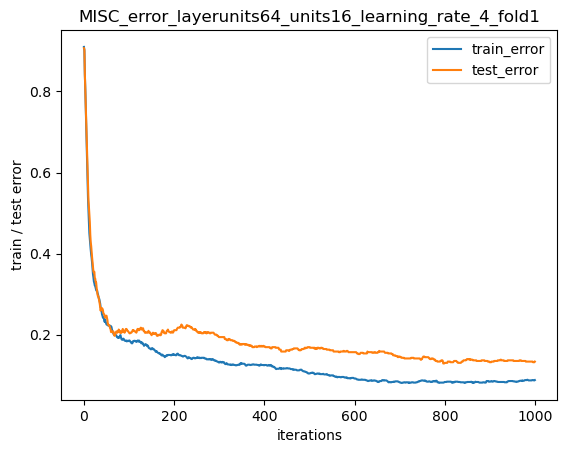

[1024, 64, 16, 10]
1000
64 16 4 2 0.156832298136646


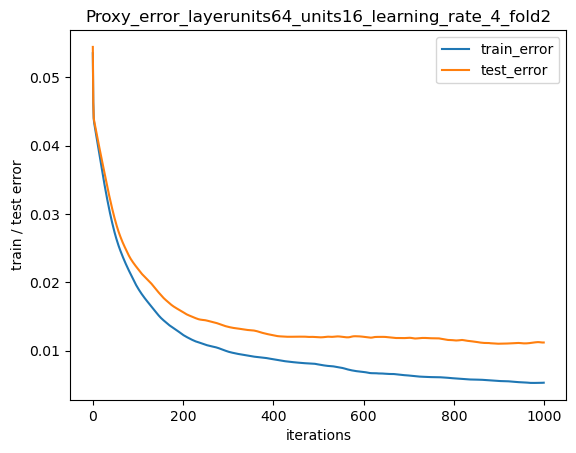

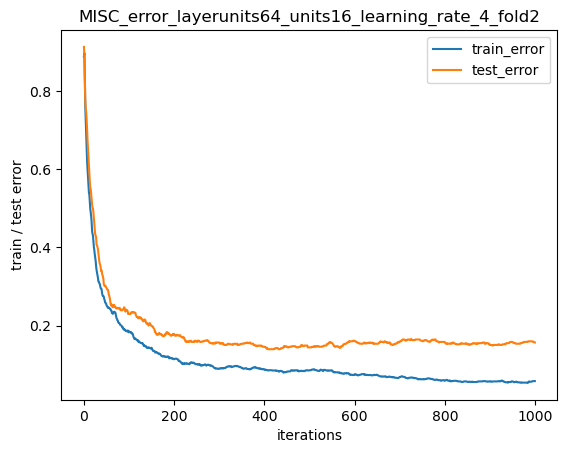

[1024, 256, 64, 10]
244
256 64 0.015625 0 0.8589147286821706


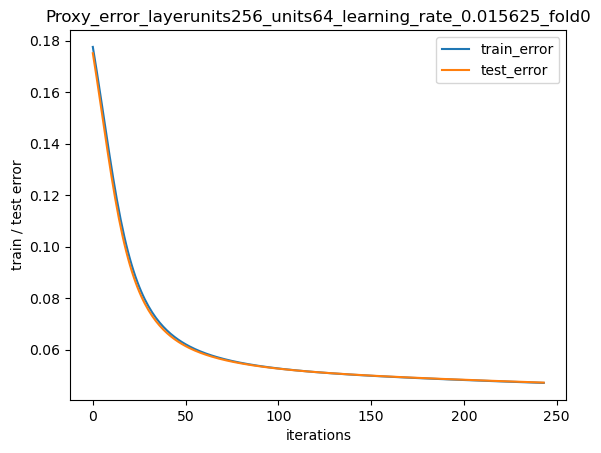

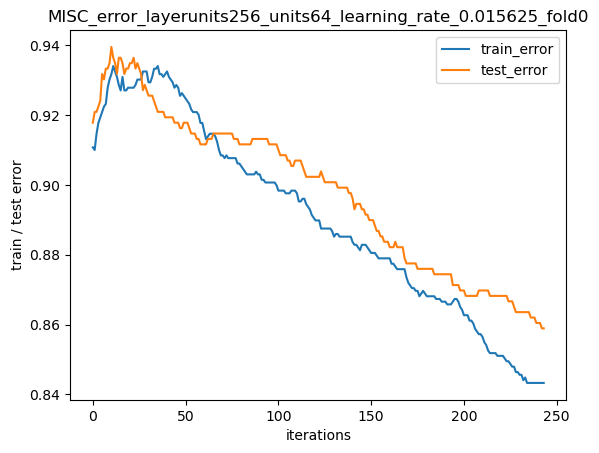

[1024, 256, 64, 10]
244
256 64 0.015625 1 0.7178294573643411


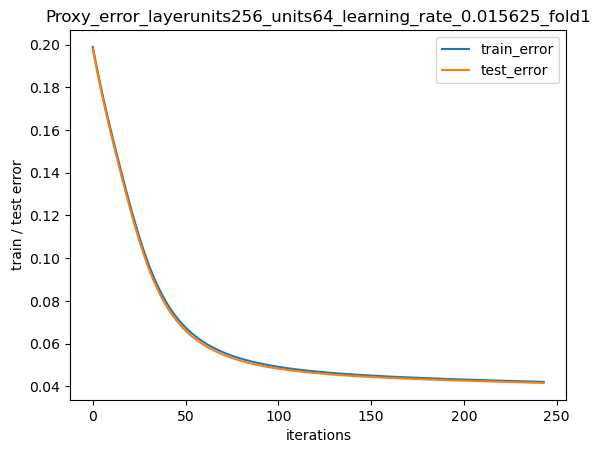

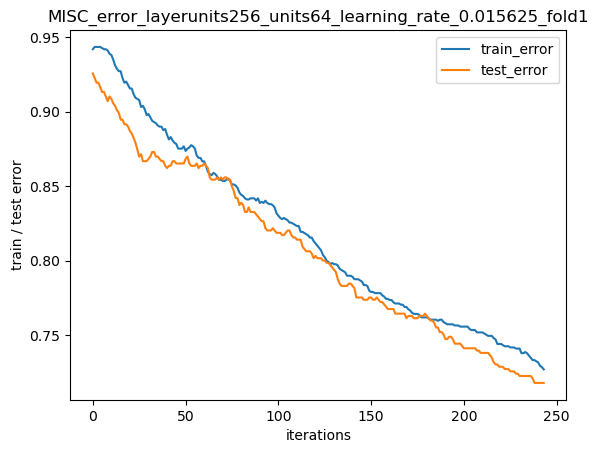

[1024, 256, 64, 10]
244
256 64 0.015625 2 0.8338509316770186


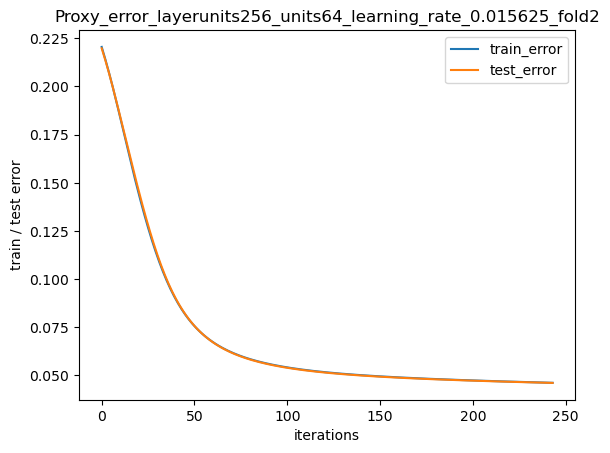

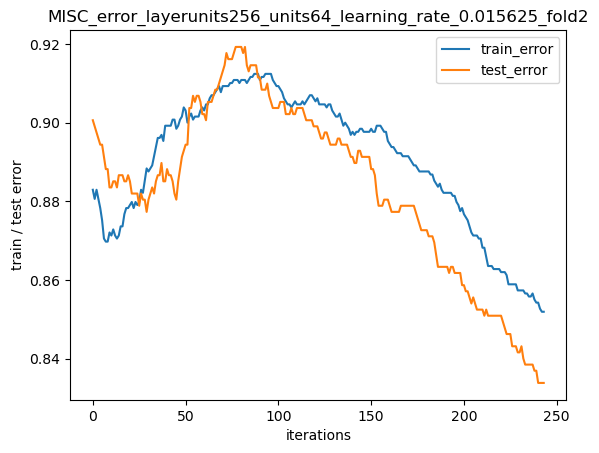

[1024, 256, 64, 10]
244
256 64 0.0625 0 0.413953488372093


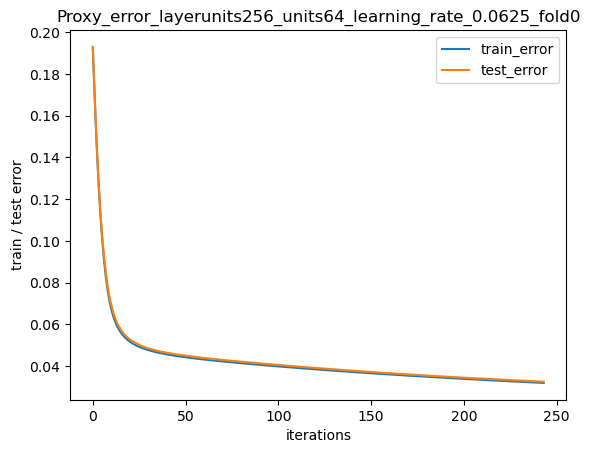

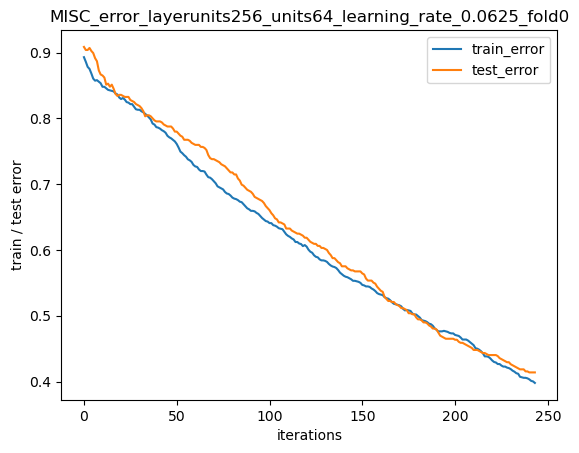

[1024, 256, 64, 10]
244
256 64 0.0625 1 0.4790697674418605


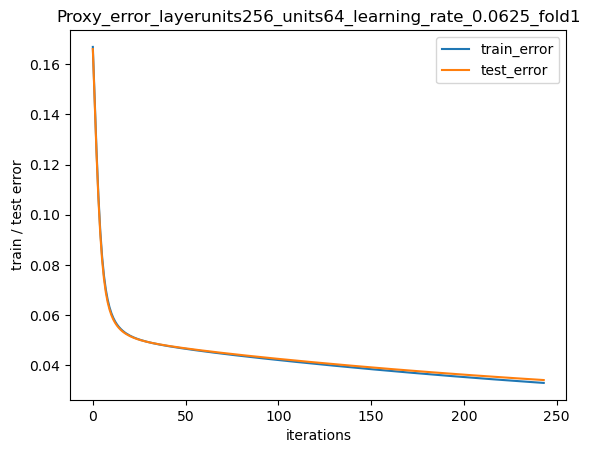

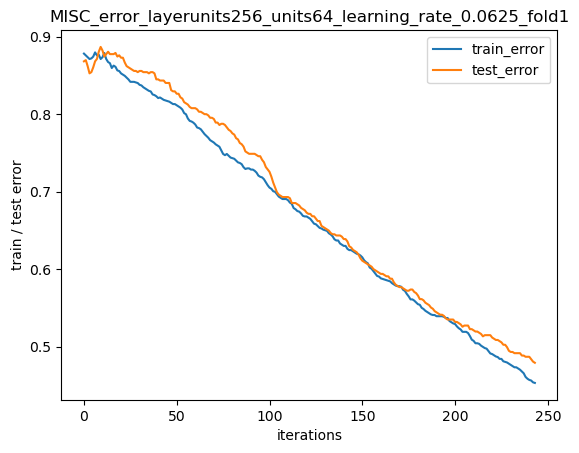

[1024, 256, 64, 10]
244
256 64 0.0625 2 0.4145962732919255


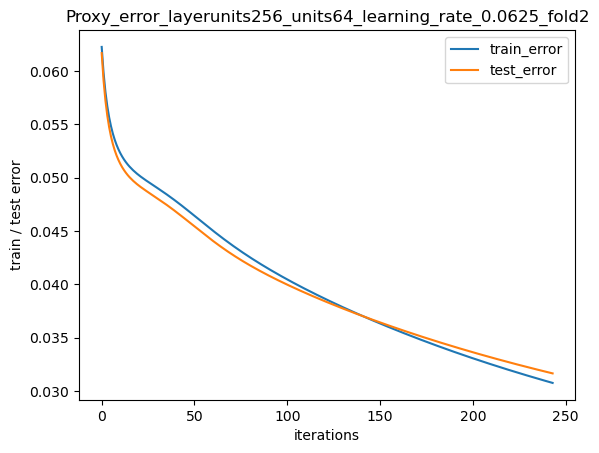

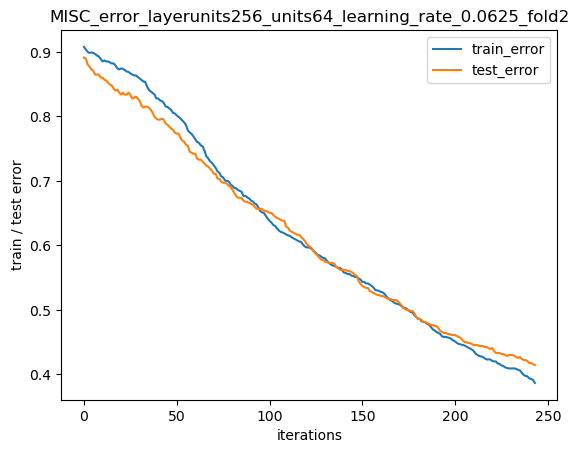

[1024, 256, 64, 10]
244
256 64 0.25 0 0.13953488372093026


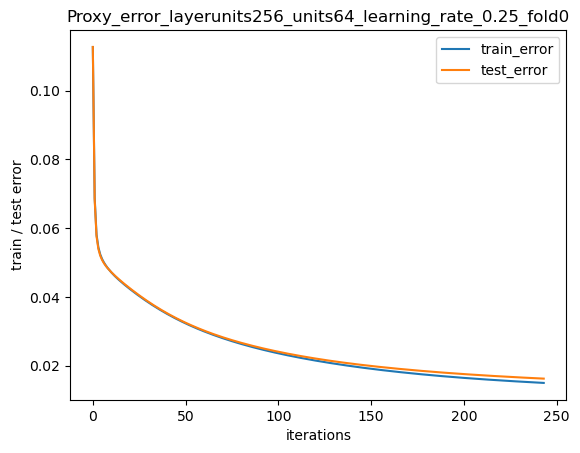

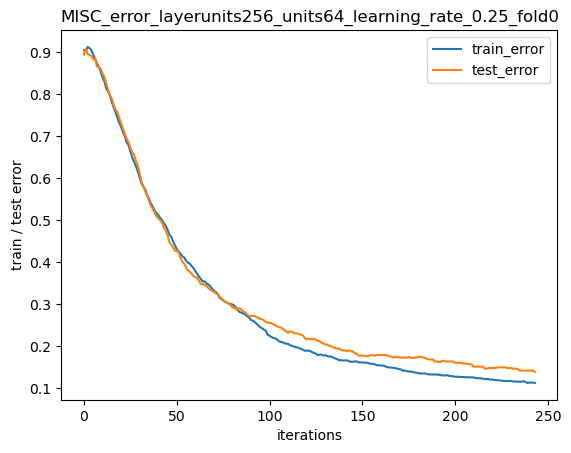

[1024, 256, 64, 10]
244
256 64 0.25 1 0.14108527131782944


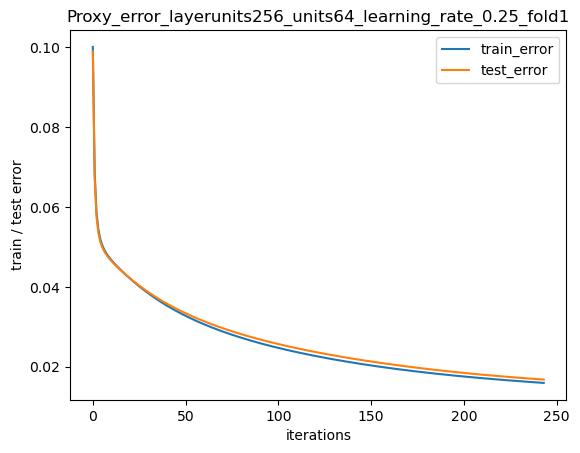

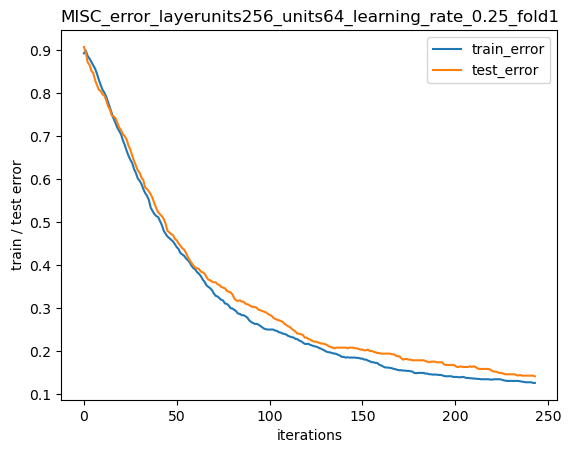

[1024, 256, 64, 10]
244
256 64 0.25 2 0.2080745341614907


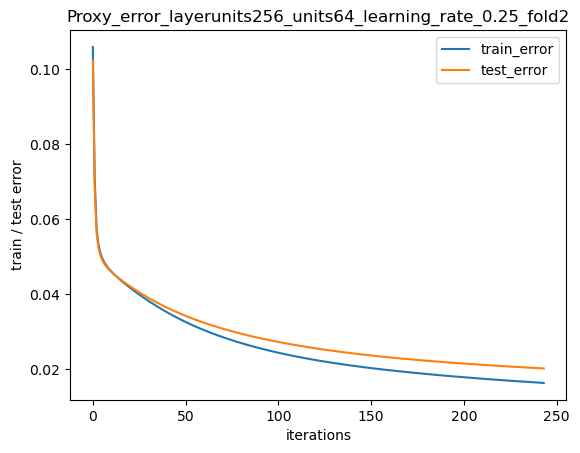

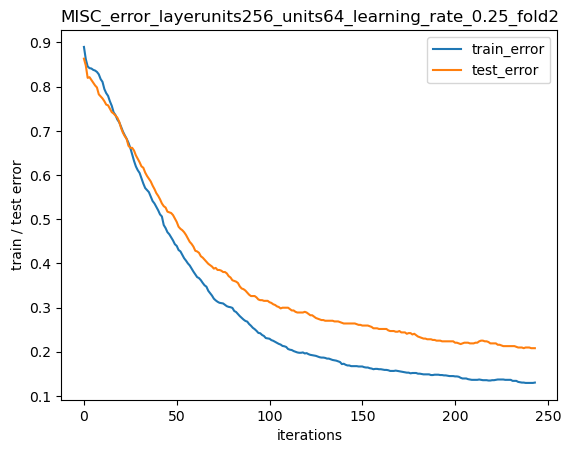

[1024, 256, 64, 10]
244
256 64 1 0 0.09922480620155039


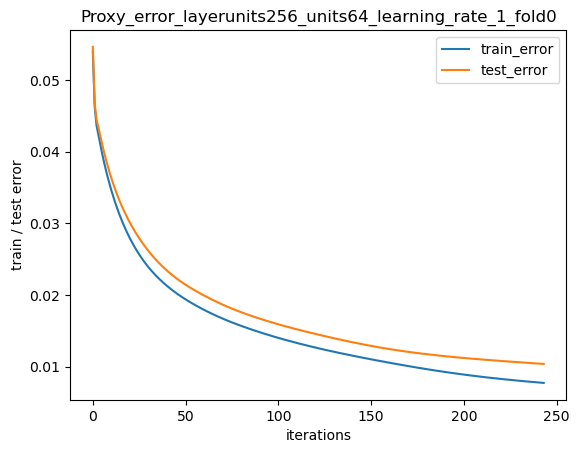

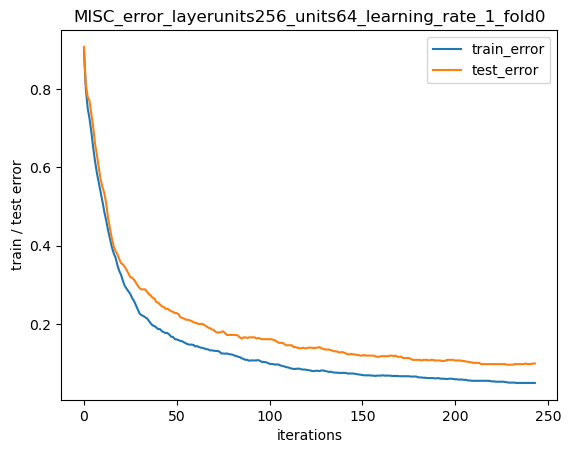

[1024, 256, 64, 10]
244
256 64 1 1 0.07751937984496127


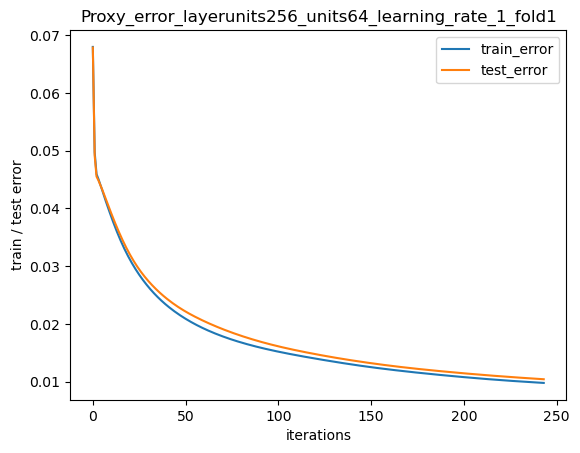

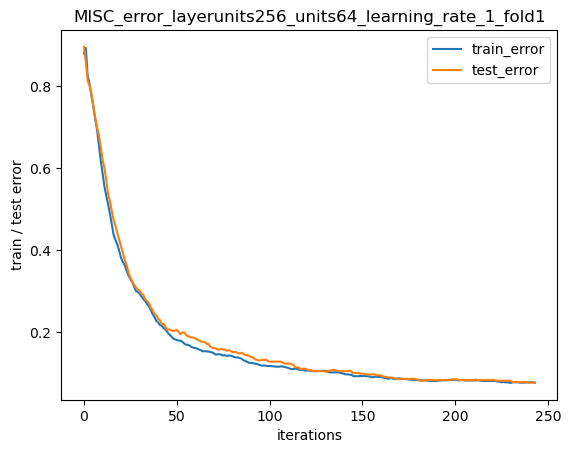

[1024, 256, 64, 10]
244
256 64 1 2 0.11335403726708071


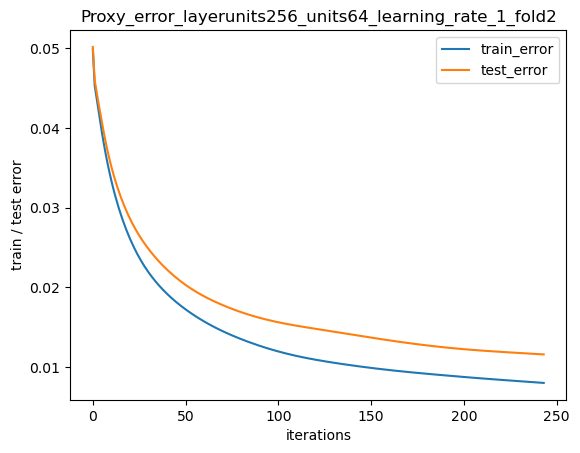

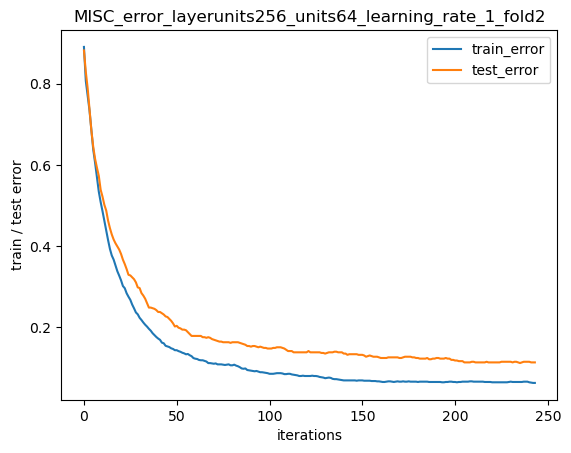

[1024, 256, 64, 10]
244
256 64 4 0 0.06666666666666665


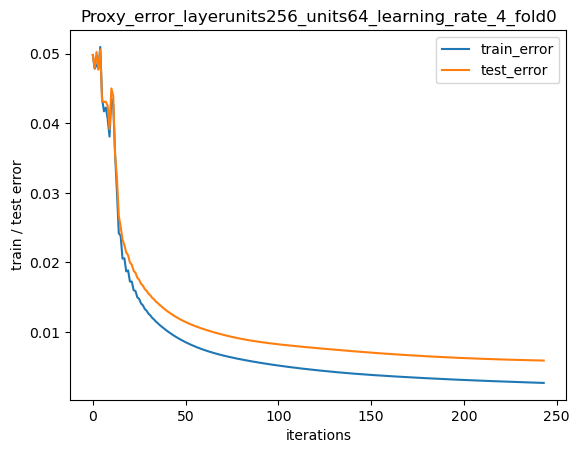

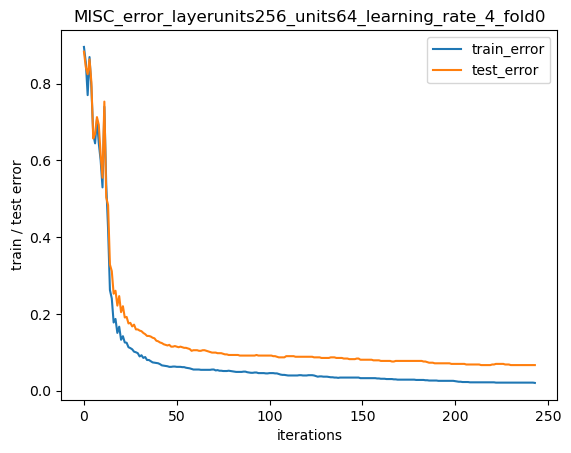

[1024, 256, 64, 10]
244
256 64 4 1 0.04031007751937987


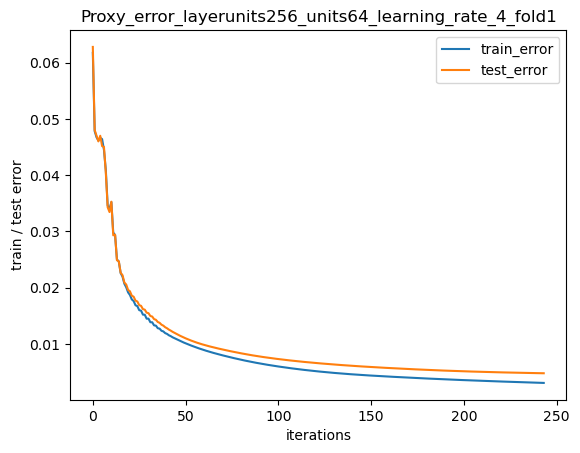

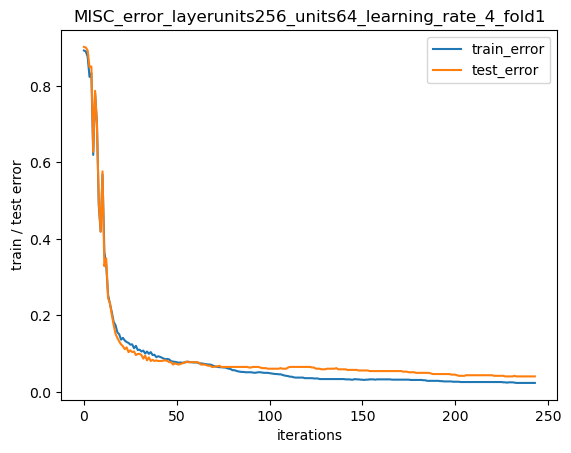

[1024, 256, 64, 10]
244
256 64 4 2 0.08229813664596275


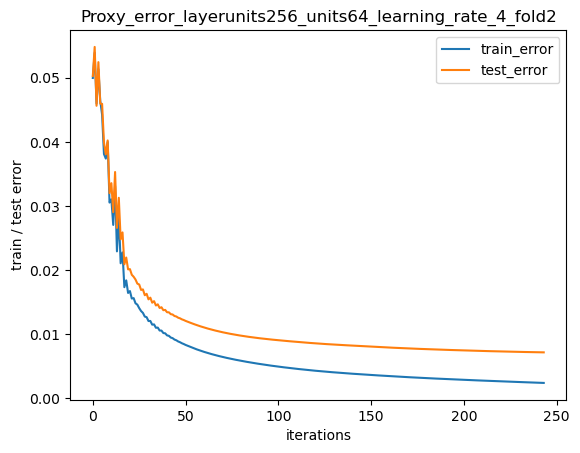

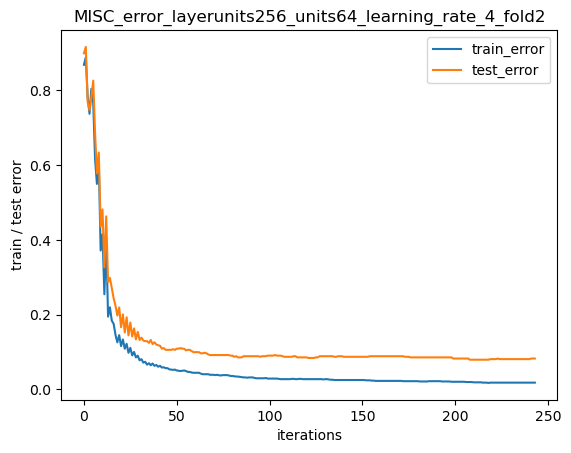

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [21:41<00:00, 1301.67s/it]

   numberunitslayer1  numberunitslayer2  learn_rate  misc_test  misc_train  \
0                 64                 16    0.015625   0.776163    0.752047   
1                 64                 16    0.062500   0.501046    0.487076   
2                 64                 16    0.250000   0.320572    0.258538   
3                 64                 16    1.000000   0.223877    0.168054   
4                 64                 16    4.000000   0.153053    0.089719   
5                256                 64    0.015625   0.803532    0.807382   
6                256                 64    0.062500   0.435873    0.412623   
7                256                 64    0.250000   0.162898    0.123059   
8                256                 64    1.000000   0.096699    0.063340   
9                256                 64    4.000000   0.063092    0.020425   

   RMSE_test  RMSE_train  
0   0.043792    0.043471  
1   0.040009    0.039869  
2   0.028885    0.027165  
3   0.017835    0.015034  
4   0.


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_3376\1404801235.py:58: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  scores1 = scoress.groupby(["numberunitslayer1","numberunitslayer2","learn_rate"])["misc_test","misc_train","RMSE_test","RMSE_train"].mean().reset_index()


In [26]:
#### DEEP NEURAL NETWORK FIXED HIDDEN LAYER
from tqdm import tqdm
k = 3
learning_rate_cv = [4**-3,4**-2,4**-1,4**0,4**1]
cv_method = KFold(n_splits=k, shuffle=False, random_state=None)
scores_deep = []
layer_units1 = [64,256]
layer_units2 = [16,64]
o=0
for p in tqdm(range(1,2)):
    for j in layer_units1:
        for a in learning_rate_cv:
            for i, (train_idx, test_idx) in enumerate(cv_method.split(X, y_ohe)):
                        X_cv_train, y_cv_train = X[train_idx], y_ohe[train_idx]
                        X_cv_test, y_cv_test = X[test_idx], y_ohe[test_idx]
                        o = 0
                        if j == layer_units1[1]:
                            o=o+1

                        nunits = [1024,j,layer_units2[o],10]
                        nnet_time = time_nnet(nunits)
                        print(nunits)
                        R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))
                        #R = 1000
                        print(R)

                        # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

                        opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = a, change_err_thresh=0, change_thresh=0)


                        nnet = NNet(nunits=nunits)

                        best_nnet = nnet.fit(X_cv_train,y_cv_train,X_cv_test,y_cv_test,optimizer=opt,verbose=0)
                        train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

                        print(j,layer_units2[o],a,i,test_err[-1,1])
                        plt.plot(train_err[:,0])
                        plt.plot(test_err[:,0])
                        plt.xlabel("iterations")
                        plt.ylabel("train / test error")
                        plt.title("Proxy_error_layerunits{}_units{}_learning_rate_{}_fold{}".format(j,layer_units2[o],a,i))
                        plt.legend(["train_error","test_error"])
                        plt.savefig('Graph_deep_model1/proxy_error_layerunits{}_units{}_learning_rate_{}_fold{}.png'.format(j,layer_units2[o],a,i))
                        plt.show()

                        plt.plot(train_err[:,1])
                        plt.plot(test_err[:,1])
                        plt.xlabel("iterations")
                        plt.ylabel("train / test error")
                        plt.title("MISC_error_layerunits{}_units{}_learning_rate_{}_fold{}".format(j,layer_units2[o],a,i))
                        plt.legend(["train_error","test_error"])
                        plt.savefig('Graph_deep_model2/Misclassification_error_layer{}_units{}_learning_rate_{}_fold{}.png'.format(j,layer_units2[o],a,i))
                        plt.show()
                        scores_deep.append([j,layer_units2[o],a,i,test_err[-1,1],train_err[-1,1],test_err[-1,0],train_err[-1,0]])
scoress = pd.DataFrame(scores_deep)
scoress.columns = ["numberunitslayer1","numberunitslayer2","learn_rate","fold","misc_test","misc_train","RMSE_test","RMSE_train"]
scores1 = scoress.groupby(["numberunitslayer1","numberunitslayer2","learn_rate"])["misc_test","misc_train","RMSE_test","RMSE_train"].mean().reset_index()
print(scores1)
scoress.to_csv("results/deep1model_all.csv",index = False)
scores1.to_csv("results/deep2model_avg.csv",index = False)
print("finish")

# MODEL 3 TRAINING ALL DATA

244
0.030655391120507414
0.003510301437258081
0.030655391120507414
0.003510301437258081


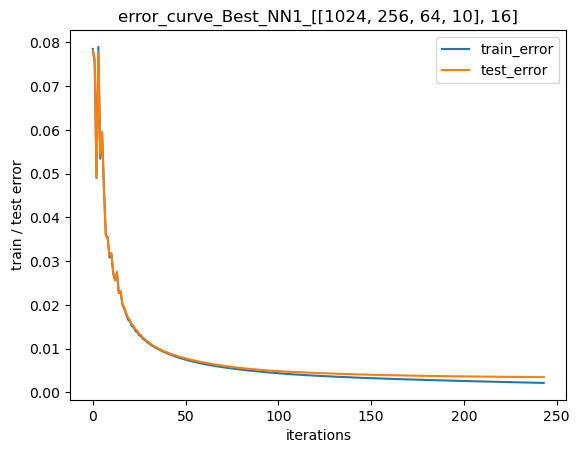

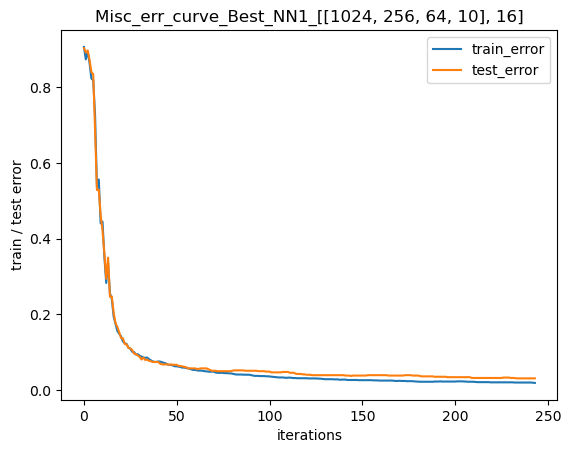

NameError: name 'pd' is not defined

In [22]:
nunits= [1024,256,64,10]
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))
#R = 1000
print(R)

# opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = 4, change_err_thresh=0, change_thresh=0)


nnet = NNet(nunits=nunits)

best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe, optimizer=opt,verbose=0)
train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)
print(test_err[-1,1])
print(test_err[-1,0])
print(test_err[-1,1])
print(test_err[-1,0])
plt.plot(train_err[:,0])
plt.plot(test_err[:,0])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("error_curve_Best_NN1_{}".format([nunits,learn_rate]))
plt.legend(["train_error","test_error"])
#plt.savefig('results/best_NN1_proxy_error.png')
plt.show()

plt.plot(train_err[:,1])
plt.plot(test_err[:,1])
plt.xlabel("iterations")
plt.ylabel("train / test error")
plt.title("Misc_err_curve_Best_NN1_{}".format([nunits,learn_rate]))
plt.legend(["train_error","test_error"])
#plt.savefig('results/best_NN1_Misc_error.png')
plt.show()

temp = pd.DataFrame()
temp["misc_err_train"] = train_err[:,1]
temp["misc_err_test"] = test_err[:,1]
temp["p_err_train"] = train_err[:, 0 ]
temp["p_err_test"] = test_err[:, 0 ]
#temp.to_csv("results/best_NN1_{}.csv".format([nunits,learn_rate]),index = False)

# EVALUATION MODEL 1,2,3 with TRIAL DATA

In [24]:
nunit = [[1024,10],[1024,64,10],[1024,256,64,10]]
name = ["perc","mod2","mod3"]
learn = [16,16,4]
comp = pd.DataFrame()
comp["true"] = y_trial.flatten()
for i  in range(3):
    
    nnet_time = time_nnet(nunit[i])

    R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

    print(R)
    # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

    opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = learn[i], change_err_thresh=0, change_thresh=0)


    nnet = NNet(nunits=nunit[i])

    best_nnet = nnet.fit(X,y_ohe,X_trial,y_trial_ohe,optimizer=opt,verbose=0)
    train_err, test_err, y_p = np.array(opt.train_err), np.array(opt.test_err),np.array(opt.y_p)
    print(test_err[-1,1])
    print(test_err[-1,0])
    output1 = out_enc.inverse_transform(y_p)[-1,]
    
    comp["classified_{}".format(name[i])] = output1
    comp["misclassification_{}".format(name[i])] = np.where(comp["true"] == comp["classified_{}".format(name[i])],1,0)
    comp["misclassification_{}".format(name[i])].sum()

comp.to_csv("results/trial_{}_{}.csv".format(nunit[i],learn[i]),index = False)
    

1000
0.04016913319238902
0.0057987943483544906
1000


C:\Users\SS Studios\AppData\Local\Temp\ipykernel_23420\712941221.py:10: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


0.03594080338266381
0.00327871092100058
244
0.039112050739957716
0.0033733169729631253


# EVALUATING MODELS WITH FIRST M DATA

In [65]:
nunit = [[1024,10],[1024,64,10],[1024,256,64,10]]
name = ["perc","mod2","mod3"]
learn = [16,16,4]
comp = pd.DataFrame()
comp["true"] = y_trial.flatten()
m_range = [10, 40, 100, 200, 400, 800, 1600]
scoresss = []
s = []
for i  in range(3):
    for k in m_range:
        scoresss = []
        nnet_time = time_nnet(nunit[i])

        R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

        print(R)
        # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)

        opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate = learn[i], change_err_thresh=0, change_thresh=0)


        nnet = NNet(nunits=nunit[i])

        best_nnet = nnet.fit(X[0:k,],y_ohe[0:k,],X_test,y_test_ohe,optimizer=opt,verbose=0)
        train_err, test_err, y_p = np.array(opt.train_err), np.array(opt.test_err),np.array(opt.y_p)
        print(test_err[-1,1])
        print(test_err[-1,0])
        scoresss.append([k,name[i],learn[i],train_err[-1,1],test_err[-1,1],train_err[-1,0],test_err[-1,0]])
        output1 = out_enc.inverse_transform(y_p)[-1,]
    
        comp["classified_{}".format([name[i],k])] = output1
        comp["misclassification_{}".format([name[i],k])] = np.where(comp["true"] == comp["classified_{}".format([name[i],k])],1,0)
        print(comp["misclassification_{}".format([name[i],k])].sum())
        plt.plot(train_err[:,0])
        plt.plot(test_err[:,0])
        plt.xlabel("iterations")
        plt.ylabel("train / test error")
        plt.title("error_curve_Best_{}_Nnet arch and alpha{}".format(name[i],[nunit[i],learn[i],k]))
        plt.legend(["train_error","test_error"])
        plt.savefig('results/m/proxy/best_proxy_error_{}_Nnet arch and alpha{}.png'.format(name[i],[nunit[i],learn[i],k]))
        plt.clf()

        plt.plot(train_err[:,1])
        plt.plot(test_err[:,1])
        plt.xlabel("iterations")
        plt.ylabel("train / test error")
        plt.title("Misc_err_curve_Best_{}_Nnet arch and alpha{}".format(name[i],[nunit[i],learn[i],k]))
        plt.legend(["train_error","test_error"])
        plt.savefig('results/m/misc/best_Misc_error_{}_Nnet arch and alpha{}.png'.format(name[i],[nunit[i],learn[i],k]))
        plt.clf()
        temp = pd.DataFrame()
        temp["misc_err_train"] = train_err[:,1]
        temp["misc_err_test"] = test_err[:,1]
        temp["p_err_train"] = train_err[:, 0 ]
        temp["p_err_test"] = test_err[:, 0 ]
        temp.to_csv("results/m/best_{}_{}.csv".format(name[i],[nunit[i],learn[i],k]),index = False)
        s.append(scoresss)

1000
0.6575052854122622
0.06510518649505115
324
1000
0.5169133192389006
0.04496250473566419
457
1000
0.3033826638477801
0.028638338059878723
659
1000
0.16384778012684986
0.017819299926515285
791
1000
0.10359408033826634
0.01240504124821283
848
1000
0.06553911205073992
0.008033526191209263
884
1000
0.04016913319238902
0.005994452054593864
908
1000
0.6088794926004228
0.040962865266629025
370
1000
0.38372093023255816
0.029310020600028342
583
1000
0.22093023255813948
0.018836584826767883
737
1000
0.17758985200845667
0.015342260419808434
778
1000
0.09408033826638473
0.007591061047153474
857
1000
0.06236786469344613
0.005504665414975139
887
1000
0.04016913319238902
0.0036324571304262514
908
244
0.781183932346723
0.048365499327269246
207
244
0.5021141649048626
0.03386890417903708
471
244
0.2727272727272727
0.022448922951463165
688
244
0.17547568710359407
0.01622239609042296
780
244
0.10359408033826634
0.011394637334216546
848
244
0.07293868921775903
0.007205931559473605
877
244
0.041226215644

<Figure size 640x480 with 0 Axes>

In [58]:
ai = pd.DataFrame(s)
ai[["m","model","alpha","train_misc","test_misc","train_proxy","test_proxy"]] = pd.DataFrame(ai[0].tolist(), index= ai.index)

# PLOTING THE M CURVE

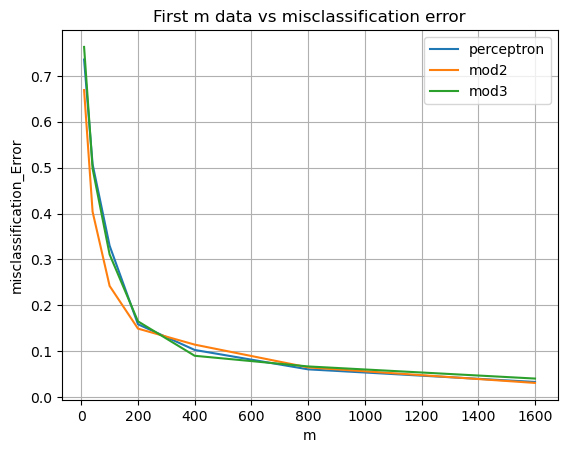

In [64]:

plt.plot(ai[ai.model == name[0]].m,ai[ai.model == name[0]].test_misc)
plt.plot(ai[ai.model == name[1]].m,ai[ai.model == name[1]].test_misc)
plt.plot(ai[ai.model == name[2]].m,ai[ai.model == name[2]].test_misc)
plt.xlabel("m")
plt.ylabel("misclassification_Error")
plt.title("First m data vs misclassification error")
plt.legend(["perceptron",name[1],name[2]])
plt.grid()
plt.show()

In [54]:
ai[0]

0     [10, perc, 16, 0.0, 0.7357293868921776, 2.3368...
1     [40, perc, 16, 0.0, 0.507399577167019, 3.22524...
2     [100, perc, 16, 0.0, 0.32980972515856233, 2.45...
3     [200, perc, 16, 0.0, 0.15856236786469347, 1.74...
4     [400, perc, 16, 0.0, 0.10253699788583515, 2.38...
5     [800, perc, 16, 0.0, 0.060253699788583526, 2.1...
6     [1600, perc, 16, 0.0, 0.03276955602537002, 2.2...
7     [10, mod2, 16, 0.0, 0.6691331923890063, 0.0001...
8     [40, mod2, 16, 0.0, 0.40380549682875266, 0.000...
9     [100, mod2, 16, 0.0, 0.2420718816067653, 0.000...
10    [200, mod2, 16, 0.0, 0.14904862579281186, 0.00...
11    [400, mod2, 16, 0.0, 0.11416490486257924, 0.00...
12    [800, mod2, 16, 0.0, 0.06448202959830862, 4.53...
13    [1600, mod2, 16, 0.0006249999999999867, 0.0306...
14    [10, mod3, 4, 0.0, 0.7632135306553911, 0.01071...
15    [40, mod3, 4, 0.0, 0.4978858350951374, 0.00935...
16    [100, mod3, 4, 0.0, 0.3107822410147991, 0.0065...
17    [200, mod3, 4, 0.0, 0.16490486257928116, 0

# WEIGHT PARAMETER INTERPRETATION

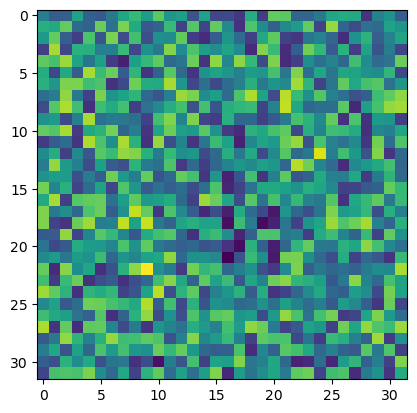

In [30]:
  plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32),cmap = "gray")